# Objetivo.

Determinar computacionalmente la confiabilidad del TPA.

1. Método de función inversa.
2. Método de regresion.


In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd
from scipy.stats import moment
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta
sns.set_theme()

In [2]:
# Función ajustar
def fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+(z/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample 
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+(z/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], abs(señal[i]*desv)) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Funcion para verificar teorema del limite central

    Parametros
    -----------
    s: Arreglo
     Arreglo de datos a los que se quieren aplicar el teorema
    k: float
     Numero de datos para efectuar el promedio

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


# Datos asumidos como reales

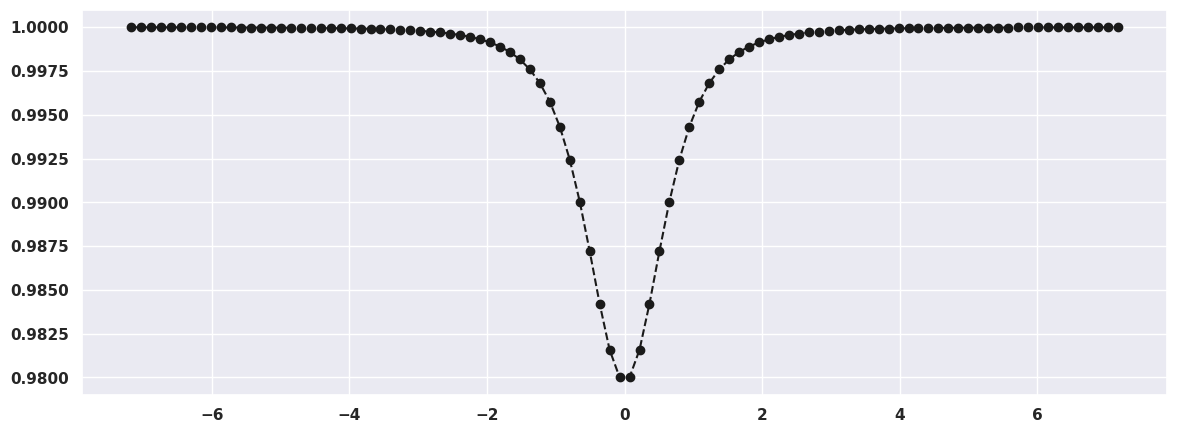

In [3]:
fig=plt.figure(figsize=(14,5))
######################## PARAMETROS QUE SE ASUMEN COMO LOS REALES
beta = 3.4e-11 # TPA seed in (m/W )
L= 1e-3 # thickness in (m).
Pavg = 200e-3# Average power in (W)
Tp =  200e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
focal =15e-2 # Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 2.6e-1 # linear absorption in (1/m) 
R =0.33 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ
w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
z0 = np.pi*w0**2/wl # Rayleigh range
z=np.linspace(-1/2*focal,1/2*focal,100)#focal distance [m]
T=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
val_min=min(T)
index=T.index(min(T))
plt.plot(z/z0,T,'--ko',label='simulated signal')
#plt.plot(corriente,Td,'--ro',label='derivada')

# 1) Perspectiva 1.
En esta perspectiva se cuenta con la siguiente ecuación que da el parametro físico de interes:

$$\beta=\left[\frac{1}{2\sqrt{2}} \frac{(1-R) I_0(f)L_{eff}}{1+\left(\frac{d_s-f}{z_0(f)}\right)^{2}} \right]^{-1}\left[1-T(f,β;\{L, P_{av}, T_{p}, w_{l}, D, ds, C_f, \alpha, R\})\right] \hspace{2 mm} (1)$$


In [4]:
def dist_betas(N,desv,k,par): 
    '''
    Parametros
    ----------
    N: float
        Numero de valores con los que se va a formar el histograma
    desv: float
        Arreglo con distancias focales utilizadas.
    k: float
        indice del arreglo de la distancia focal.
    par: array
        arreglo de 0 o 1 dependiendo de cual parametro se quiera investigar.
        [L,P,T,wl,D,focal,Cf,alpha,R,freq,trans,z]

    La función devuelve la distribucion de beta
    '''
  # Cont,edra valores de TPA
    TPA=[]
    TT=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
    trans=TT[k] #Minimo de la señal simulada.  
    er=desv/(1.96*100)
    er_L=er*par[0]
    er_P=er*par[1]
    er_T=er*par[2]
    er_wl=er*par[3]
    er_D=er*par[4]
    er_focal=er*par[5]
    er_Cf=er*par[6]
    er_a=er*par[7]
    er_R=er*par[8]
    er_freq=er*par[9]
    er_trans=er*par[10]
    er_z=er*par[11]


    for ii in range(N):


        L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
        z_f = np.random.normal(z[k],abs(z[k])*er_z,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,R*er_R,1) # Reflectance
        freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,abs(trans)*er_trans,1)
        focal_f=np.random.normal(focal,focal*er_focal,1) 
        
        TPA.append(BETA(trans_f,z_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,Cf_f,alfa_f,R_f,freq_f)[0]*1e11)
      
    
    return TPA

# Analisis

El resultado muestra que sin importar el error relativo en el regimen Gaussiano, podemos decir que la medida es confiable, ¿tiene esto sentido?



In [5]:
n=-30
desvf=[]
muf=[]
decis=[]
params=np.ones(12)
er_r=np.linspace(0.005,10,100) #Porcentaje de error

for c in er_r:
    
    beta_hist=np.array(dist_betas(500,c,n,params))
    d1=confirm_gauss(beta_hist)
    decis.append(d1)

    if d1==1:
        (mu, sigma) = norm.fit(beta_hist)
        muf.append(mu)
        desvf.append(sigma)
    else:
        muf.append(np.mean(beta_hist))
        desvf.append(np.std(beta_hist,ddof=1))

for i in range(len(decis)):

    if i<=(len(decis)-4):

        if ((decis[i]==0) and (decis[i+1]==0) and (decis[i+2]==0) and (decis[i+3]==0)):
            
            lim=i
            break
    
    
    else:
        lim=i

    
    
muf=np.array(muf)
desvf=np.array(desvf)
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

In [6]:
n2=index
desvf2=[]
muf2=[]
decis2=[]
params=np.ones(12)
er_r=np.linspace(0.005,10,100) #Porcentaje de error

for c in er_r:
    
    beta_hist=np.array(dist_betas(500,c,n2,params))
    d1=confirm_gauss(beta_hist)
    decis2.append(d1)

    if d1==1:
        (mu, sigma) = norm.fit(beta_hist)
        muf2.append(mu)
        desvf2.append(sigma)

    else:
        muf2.append(np.mean(beta_hist))
        desvf2.append(np.std(beta_hist,ddof=1))

for i in range(len(decis2)):

    if i<=(len(decis2)-4):

        if ((decis2[i]==0) and (decis2[i+1]==0) and (decis2[i+2]==0) and (decis2[i+3]==0)):
            
            lim2=i
            break
    
    else:
        lim2=i

muf2=np.array(muf2)
desvf2=np.array(desvf2)
err_max2=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min2=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nplt.subplot(122)\nplt.ylabel(r'$Relative$ $error$ $[\\%]$',fontsize=15)\nplt.xlabel(r'$error$ $[\\%]$',fontsize=15)\n#plt.vlines(er_r[i],ymin=min(err_min),ymax=max(err_max),color='black',linestyles='--')\nplt.plot(er_r,err_max,'ko',label=r'$\x0crac{ \x08eta_{est}\\pm \\sigma_{est}-\x08eta_{real}}{\x08eta_{real}} \times 100$')\nplt.plot(er_r,err_min,'ko')\n#plt.plot(er_r,err_min,'bo',label=r'$\x0crac{\\left | \x08eta_{est}-\\sigma_{est}-\x08eta_{real} \right |}{\x08eta_{real}}$')\nplt.title('$Gaussian$ $region$',fontsize=20)\nplt.legend(fontsize=15)\nplt.fill_between(er_r,err_max,err_min,color='mediumturquoise')\nplt.xlim(0,er_r[i])\nplt.ylim((err_min[lim]),(err_max[lim]))\n\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96

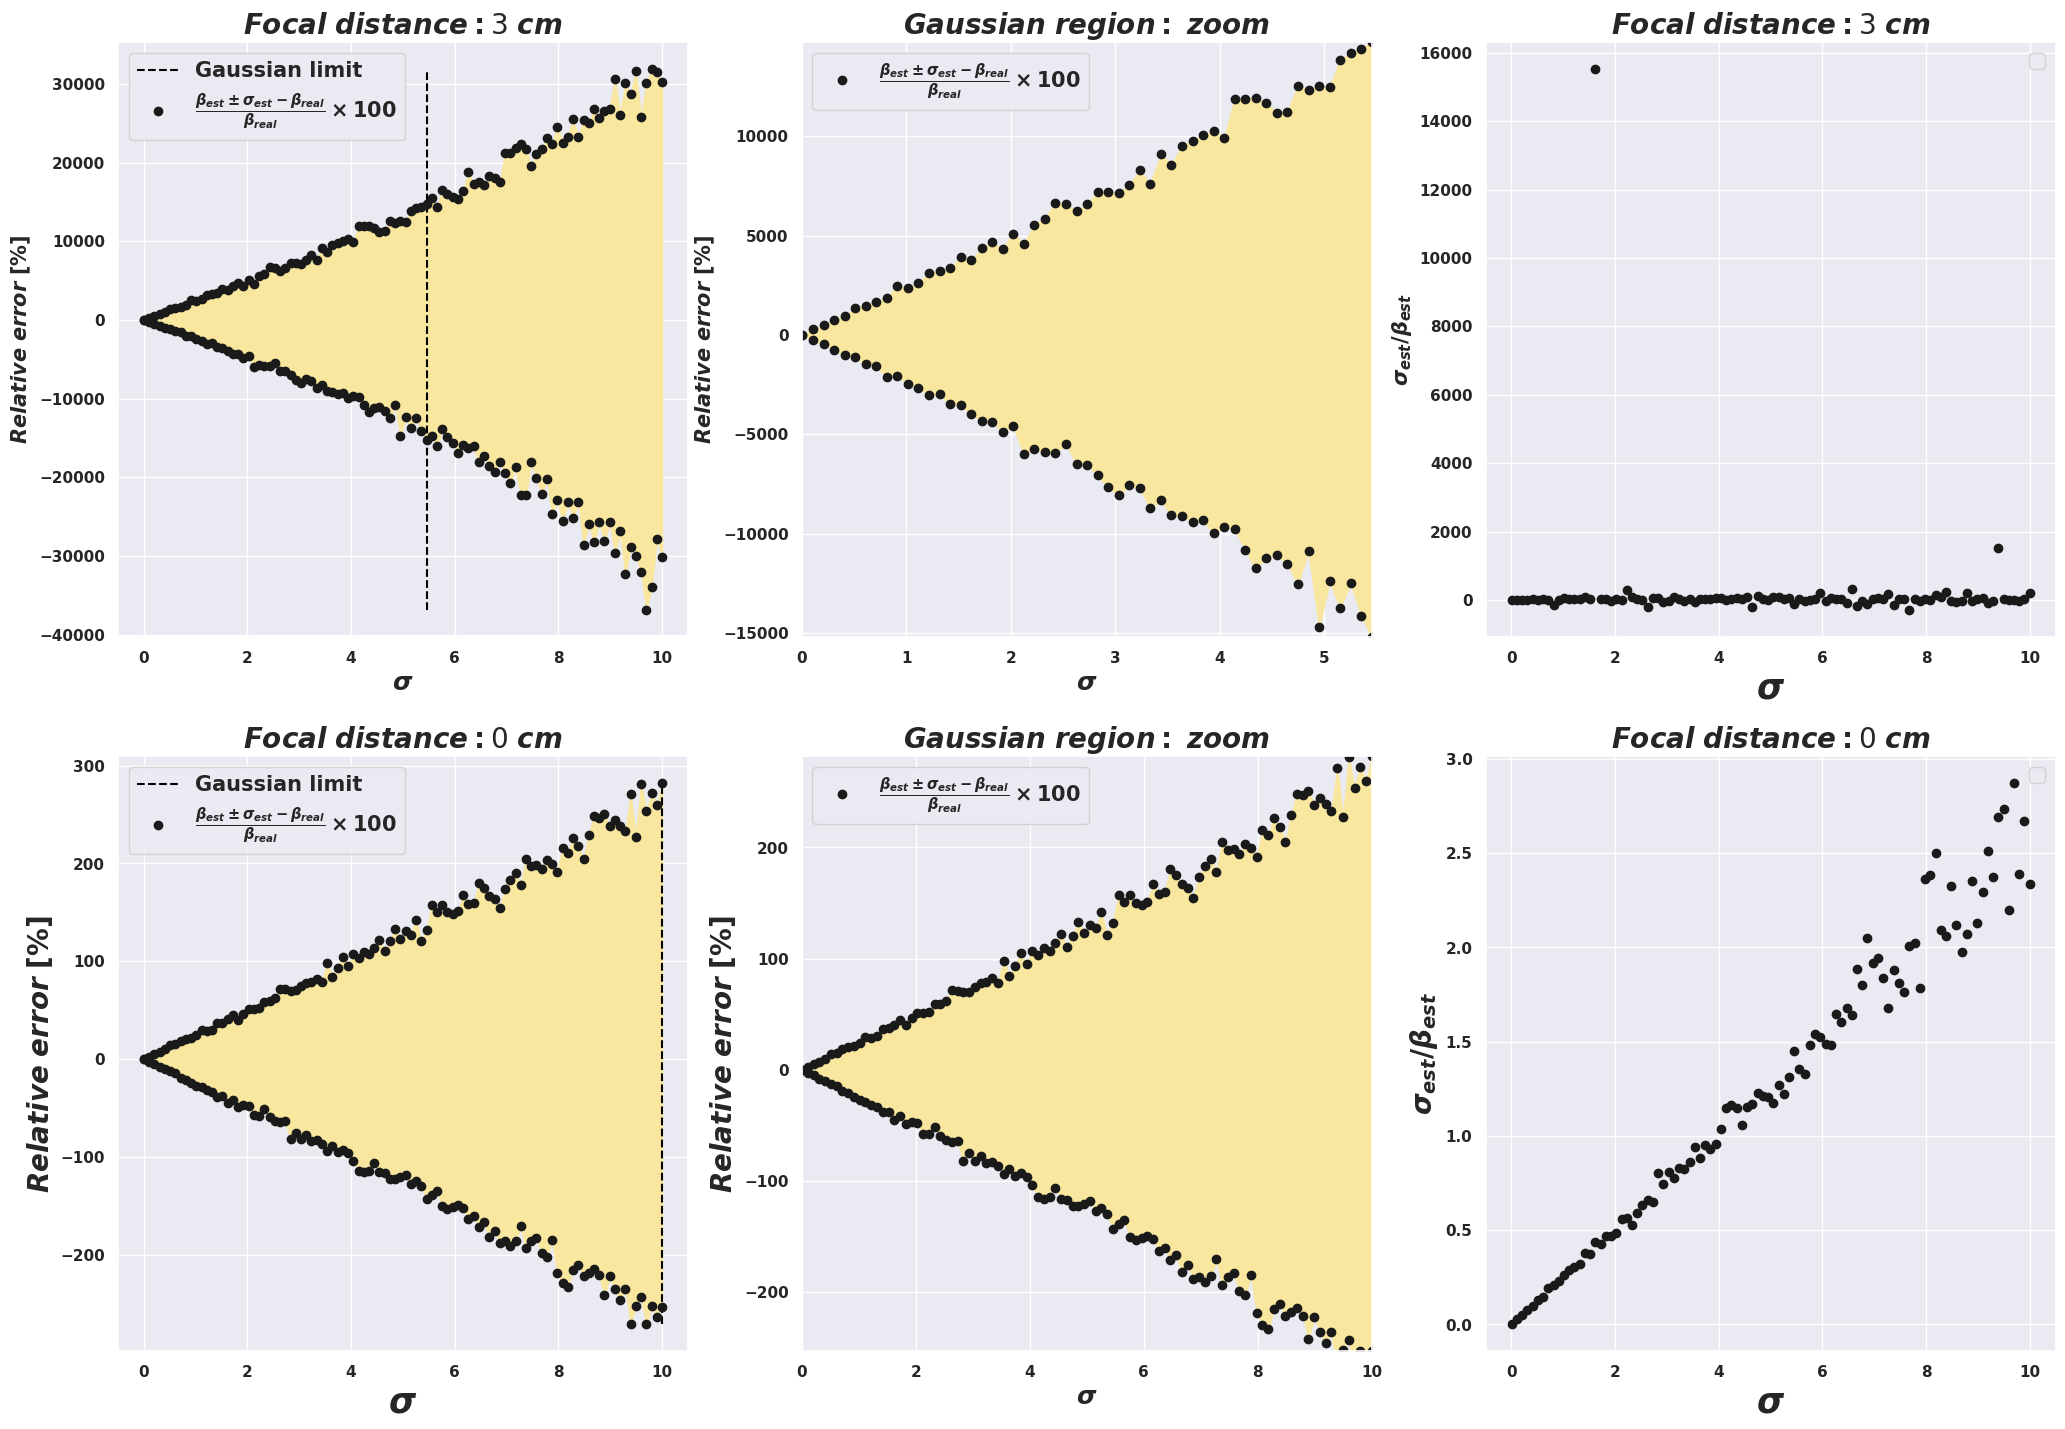

In [7]:
f=plt.figure(figsize=(25,17))

plt.subplot(231)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$\sigma$',fontsize=18)
plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round((z/z0)[n]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.subplot(232)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$\sigma$',fontsize=18)
#plt.vlines(er_r[i],ymin=min(err_min),ymax=max(err_max),color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Gaussian$ $region: $ $zoom$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
plt.xlim(0,er_r[lim])
plt.ylim((err_min[lim]),(err_max[lim]))

plt.subplot(233)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.plot(er_r,desvf/muf,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round((z/z0)[n]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)


plt.subplot(234)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.vlines(er_r[lim2],ymin=min(err_min2),ymax=max(err_max2),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max2,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round((z/z0)[index]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max2,err_min2,color='#f9e79f')

plt.subplot(235)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=18)
plt.plot(er_r,err_max2,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min2,'ko')
plt.ylim((err_min2[lim2]),(err_max2[lim2]))
plt.xlim(0,er_r[lim2])
plt.title('$Gaussian$ $region: $ $zoom$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max2,err_min2,color='#f9e79f')




plt.subplot(236)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.plot(er_r,desvf2/muf2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Focal$ $distance: $'+str(round((z/z0)[n2]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)



'''
plt.subplot(122)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)
#plt.vlines(er_r[i],ymin=min(err_min),ymax=max(err_max),color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Gaussian$ $region$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='mediumturquoise')
plt.xlim(0,er_r[i])
plt.ylim((err_min[lim]),(err_max[lim]))

f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Analisis variando solo un parametro.

In [8]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=np.array(dist_betas(500,j,index,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    

        if criterio==1:


            (mu, sigma) = norm.fit(beta_hist)
            muf2.append(mu)
            desvf2.append(sigma)


        else:


            muf2.append(np.mean(beta_hist))
            desvf2.append(np.std(beta_hist,ddof=1))
    
    
    gauss_final.append(final)
    results_mus.append(muf2)
    results_sigmas.append(desvf2)


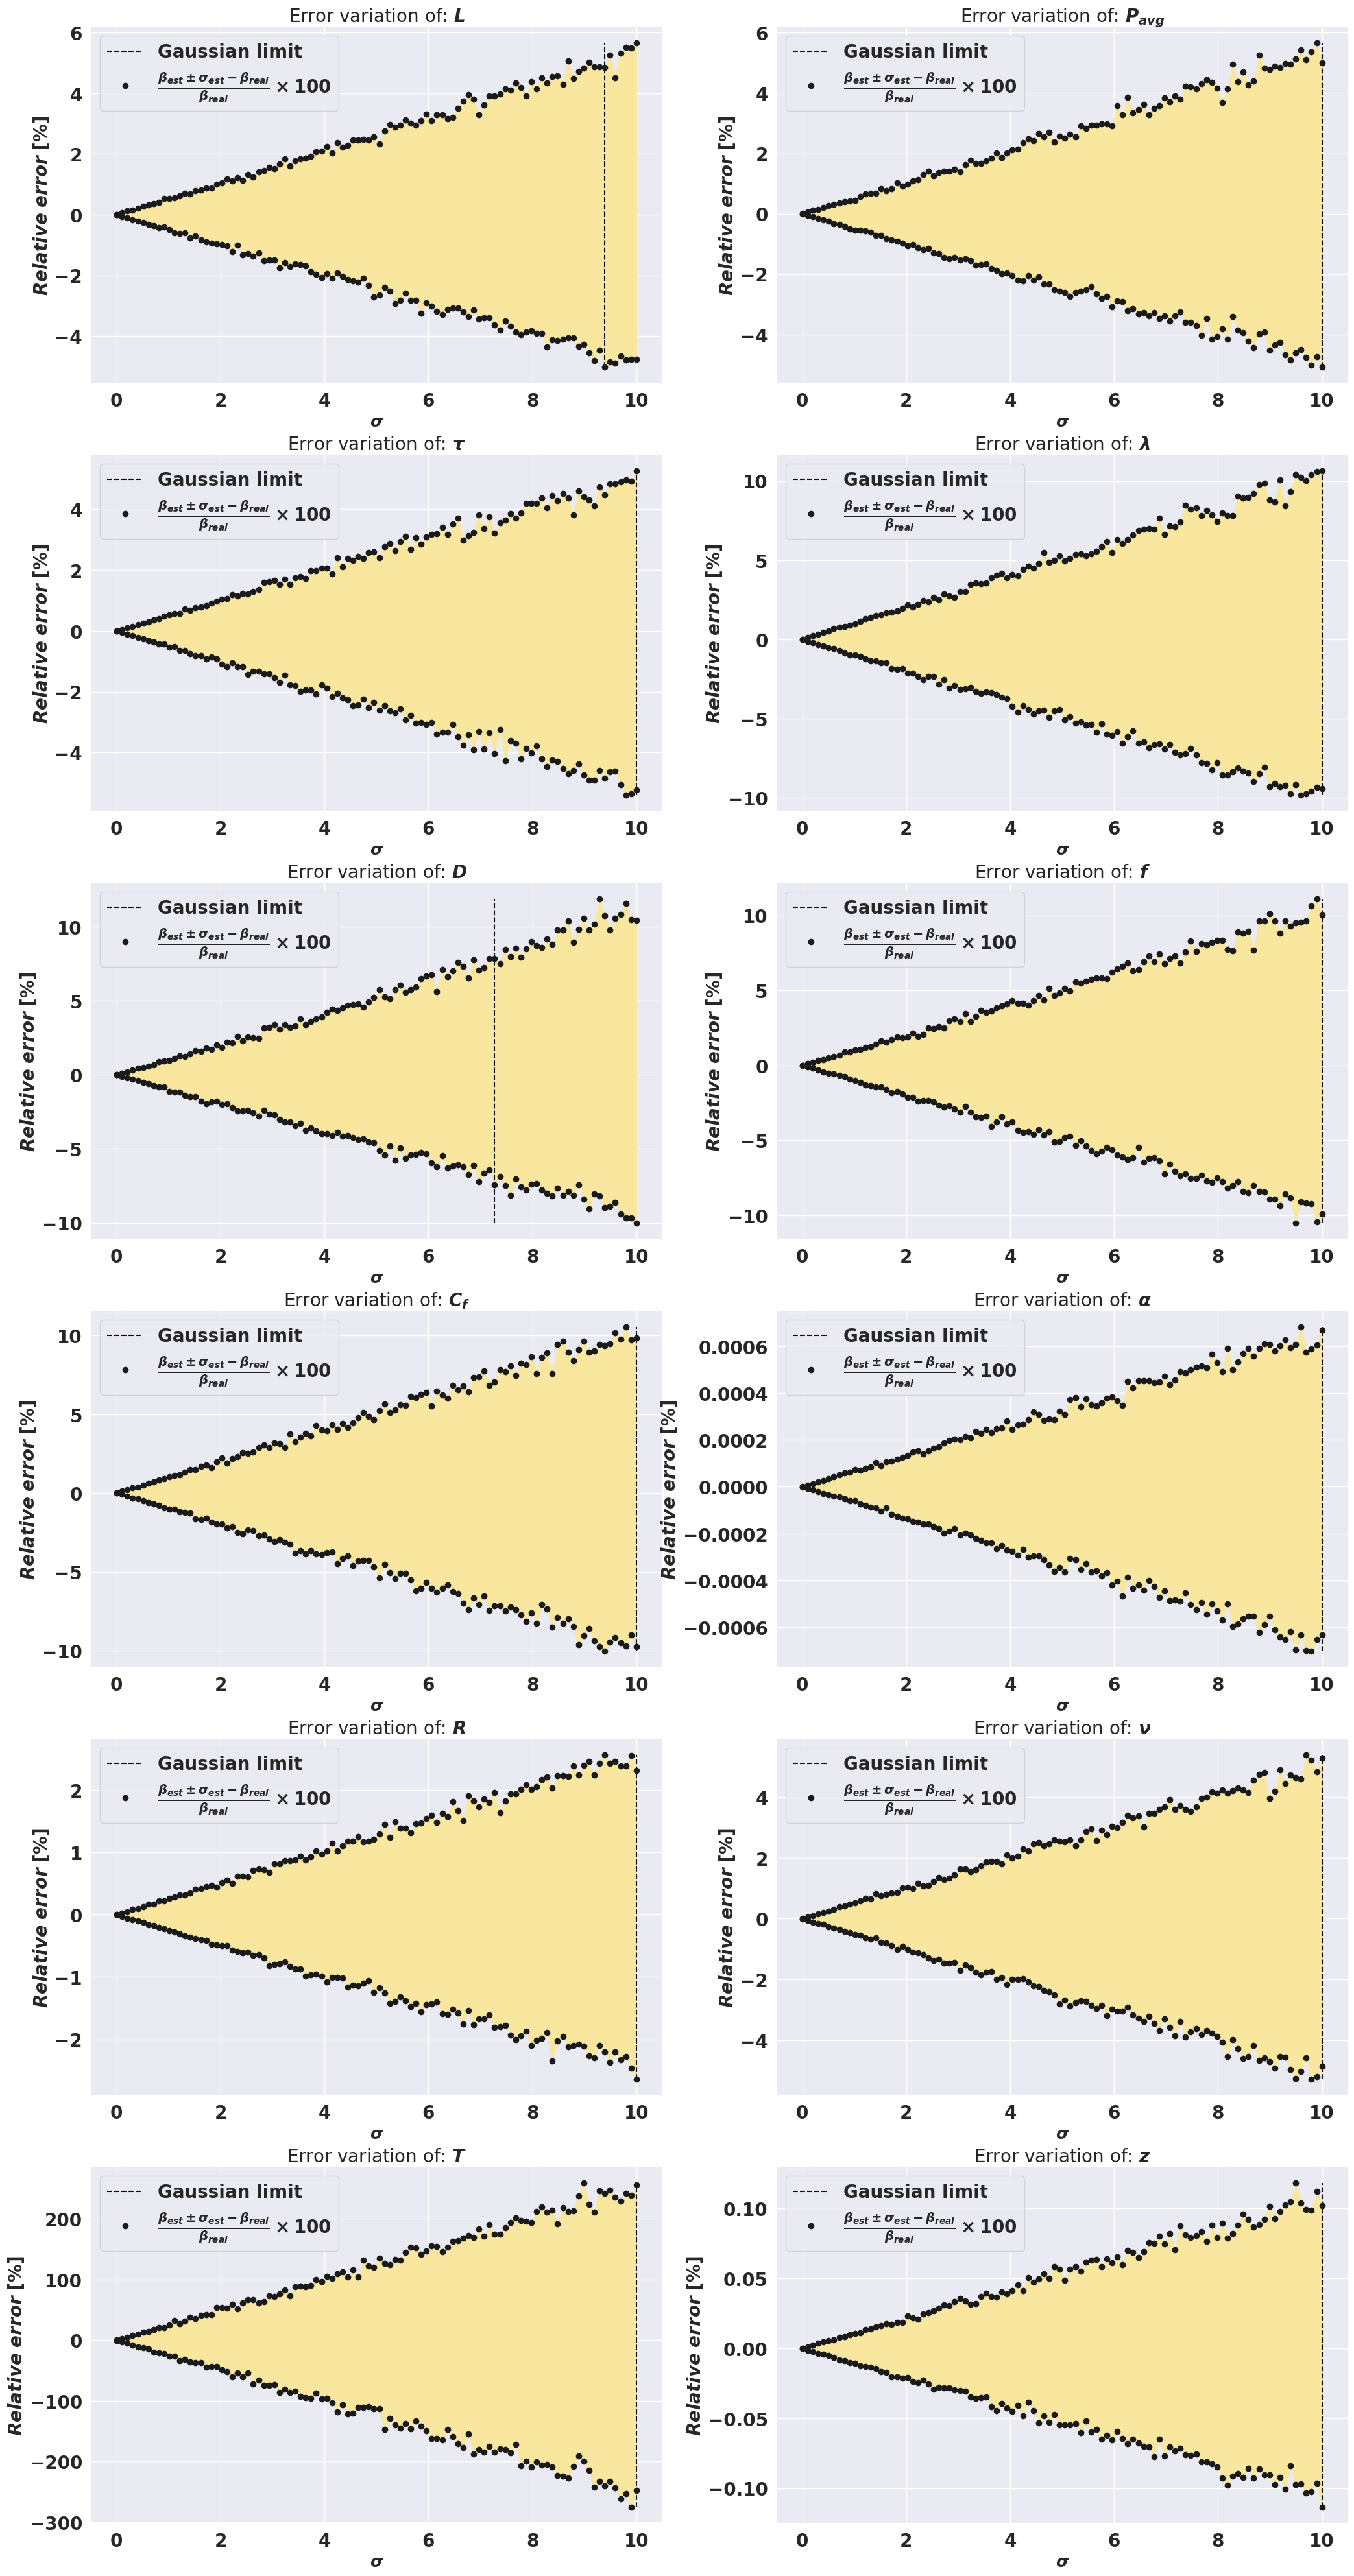

In [9]:
f=plt.figure(figsize=(25,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for i in range(0,12): 

    for j in range(0,len(gauss_final[i])): 
                 
        if j<=(len(gauss_final[i])-4):

            if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
                
                    lim=j
                    break
        else:
            lim=j
        
    
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100
    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
    plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Incertidumbre relativa.

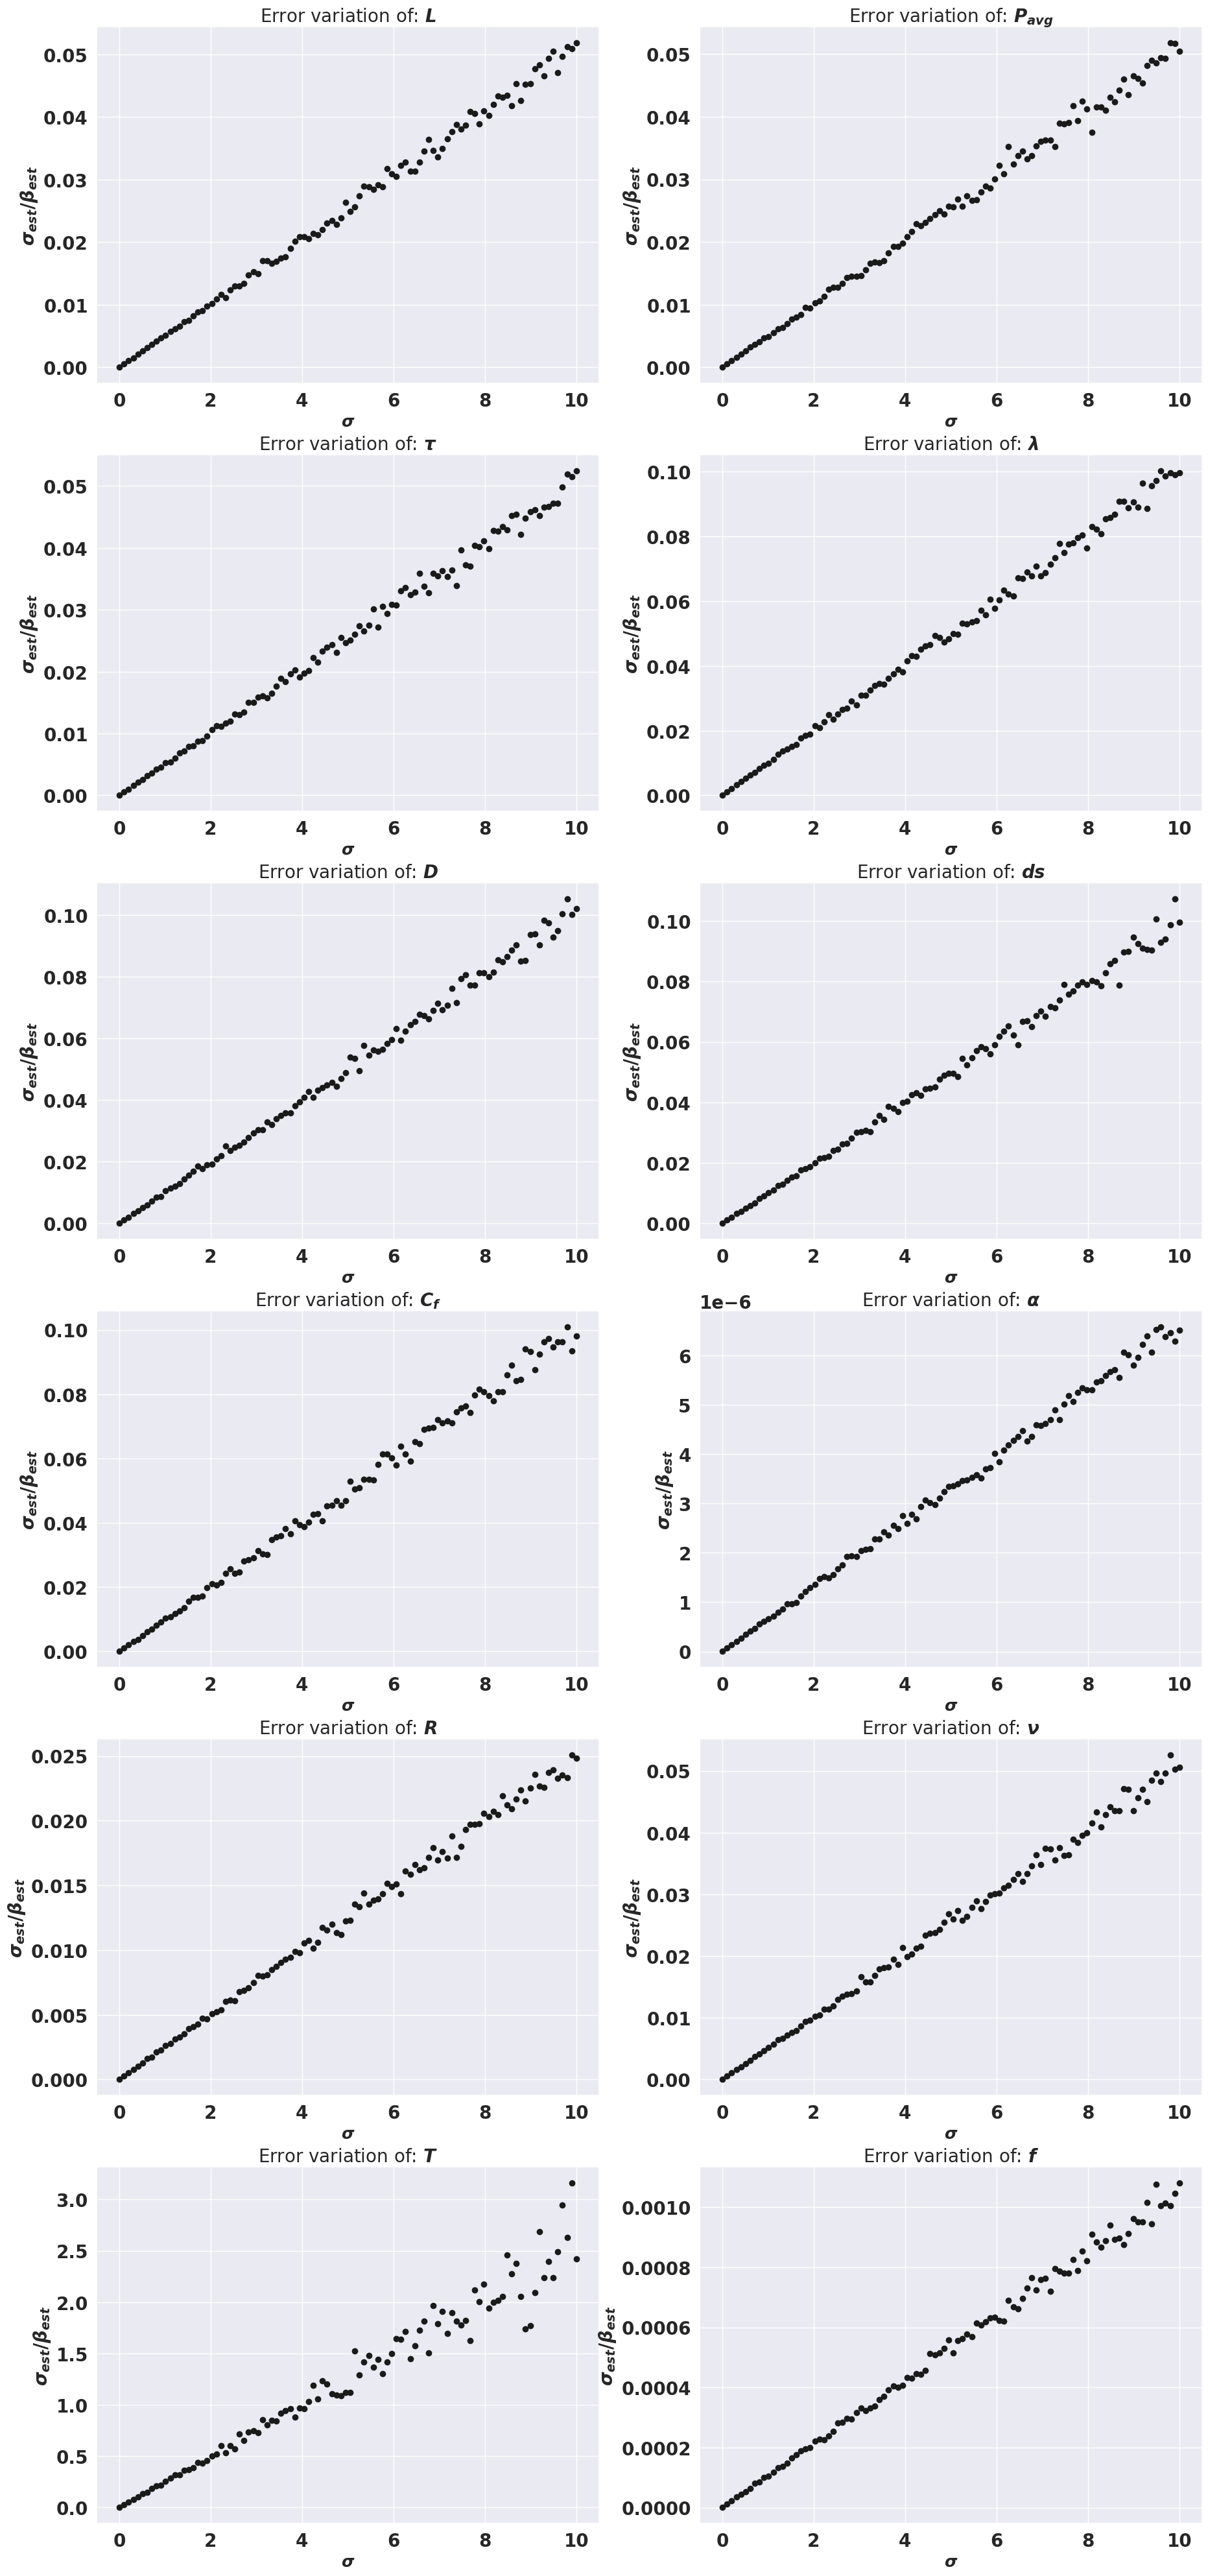

In [10]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

     
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])

    plt.subplot(6,2,iters)
    plt.plot(er_r,desvf2/muf2,'ko')
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    #plt.legend(fontsize=20)
    #plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# ¿Qué sucede en una situación real donde no tenemos control sobre nuestros errores? Aplicamos el teorema del limite central.


In [11]:
beta_med=[]
beta_sig=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
N=500
final=np.zeros((len(er_r),len(z)))
mus=np.zeros((len(er_r),len(z)))
sigmas=np.zeros((len(er_r),len(z)))
params=np.ones(12)

for k in range(len(z)):

    for c,j in enumerate(er_r):

    
        beta_hist=central(np.array(dist_betas(N,j,k,params)),100)
        mus[c,k]=np.mean(beta_hist)
        sigmas[c,k]=np.std(beta_hist)

        if abs(mus[c,k]-beta*1e11)<1.96*sigmas[c,k]:
            final[c,k]=1

        else:
            
            final[c,k]=0
        

# ¿Donde es mejor hacer el analisis?

([<matplotlib.axis.YTick at 0x7fe51c6c81f0>,
 [Text(0, 0, '0.005'),
  Text(0, 16, '1.62'),
  Text(0, 32, '3.236'),
  Text(0, 48, '4.851'),
  Text(0, 64, '6.466'),
  Text(0, 80, '8.082'),
  Text(0, 96, '9.697')])

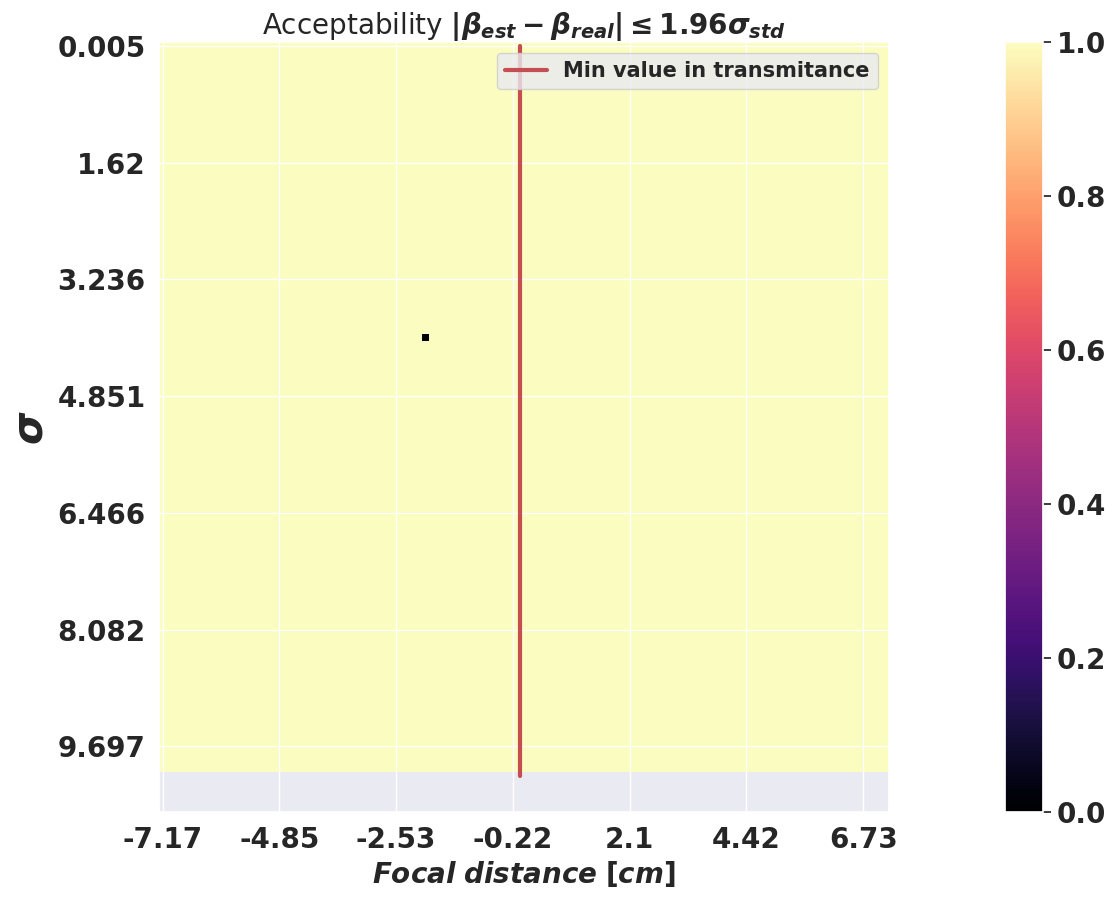

In [12]:
fig = plt.figure(figsize=(30,10))

er_r=np.linspace(0.005,10,100) #Porcentaje de error
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.imshow(final, cmap='magma')
plt.plot([index,index],[len(er_r),0],'r',lw=3,label='Min value in transmitance')
plt.ylabel('$\sigma$',fontsize=30)
plt.xlabel('$Focal$ $distance$ $[cm]$',fontsize=20)
plt.title(r'Acceptability $\left | \beta_{est}-\beta_{real} \right |\leq 1.96 \sigma_{std}$',fontsize=20)
plt.legend(fontsize=15)
plt.colorbar()

nx = (z/z0).shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round((z/z0)[::step_x],2) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)


ny = er_r.shape[0]
no_labels = 7 # how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = np.round(er_r[::step_y],3) # labels you want to see
plt.yticks(y_positions, np.sort(y_labels),fontsize=20)


# ¿Como es la medida?

In [13]:
n=-30
muf=mus[:,n]
desvf=sigmas[:,n]
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

In [14]:
n2=index
muf2=mus[:,n2]
desvf2=sigmas[:,n2]
err_max2=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
err_min2=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96\\sigma_{est}$')\nplt.ylabel(r'$\x08eta_{est}$',fontsize=15)\nplt.xlabel(r'$\\sigma_{est}$',fontsize=15)\nplt.legend()\n"

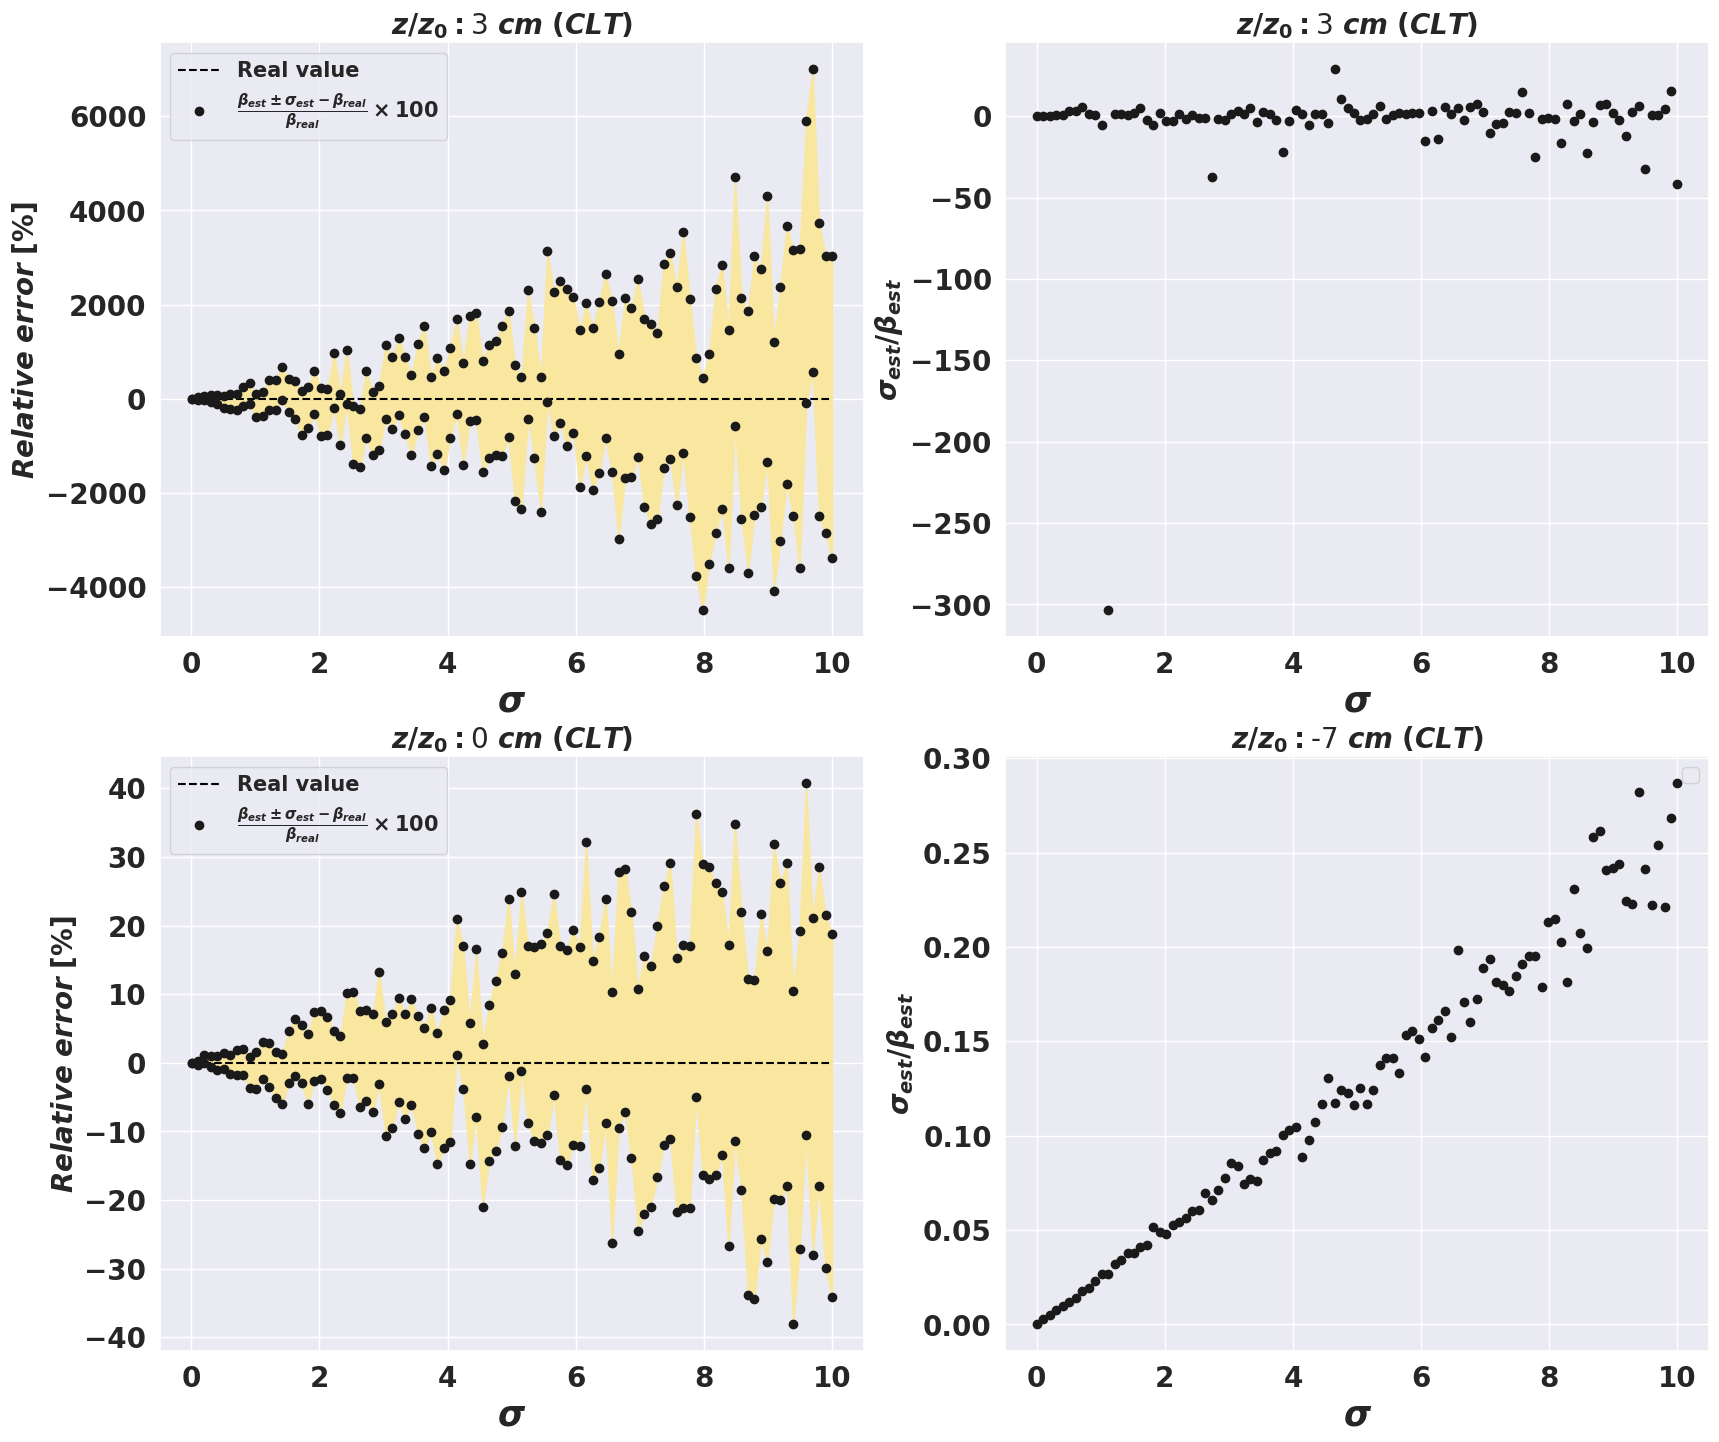

In [15]:
f=plt.figure(figsize=(20,17))

plt.subplot(221)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.hlines(0,xmin=min(er_r),xmax=max(er_r),label='Real value',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$z/z_0: $'+str(round((z/z0)[n]))+' $cm$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.subplot(222)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.plot(er_r,desvf/muf,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$z/z_0: $'+str(round((z/z0)[n]))+' $cm$ $(CLT)$',fontsize=20)


plt.subplot(223)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.hlines(0,xmin=min(er_r),xmax=max(er_r),label='Real value',color='black',linestyles='--')
plt.plot(er_r,err_max2,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$z/z_0: $'+str(round((z/z0)[n2]))+' $cm$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max2,err_min2,color='#f9e79f')


plt.subplot(224)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.plot(er_r,desvf2/muf2,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$z/z_0: $'+str(round(100*(z/z0)[n2]))+' $cm$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)


'''
f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variación en el error de cada parametro.

In [16]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=central(np.array(dist_betas(500,j,index,params[i,:])),100)
        muf2.append(np.mean(beta_hist))
        desvf2.append(np.std(beta_hist))

    results_mus.append(muf2)
    results_sigmas.append(desvf2)


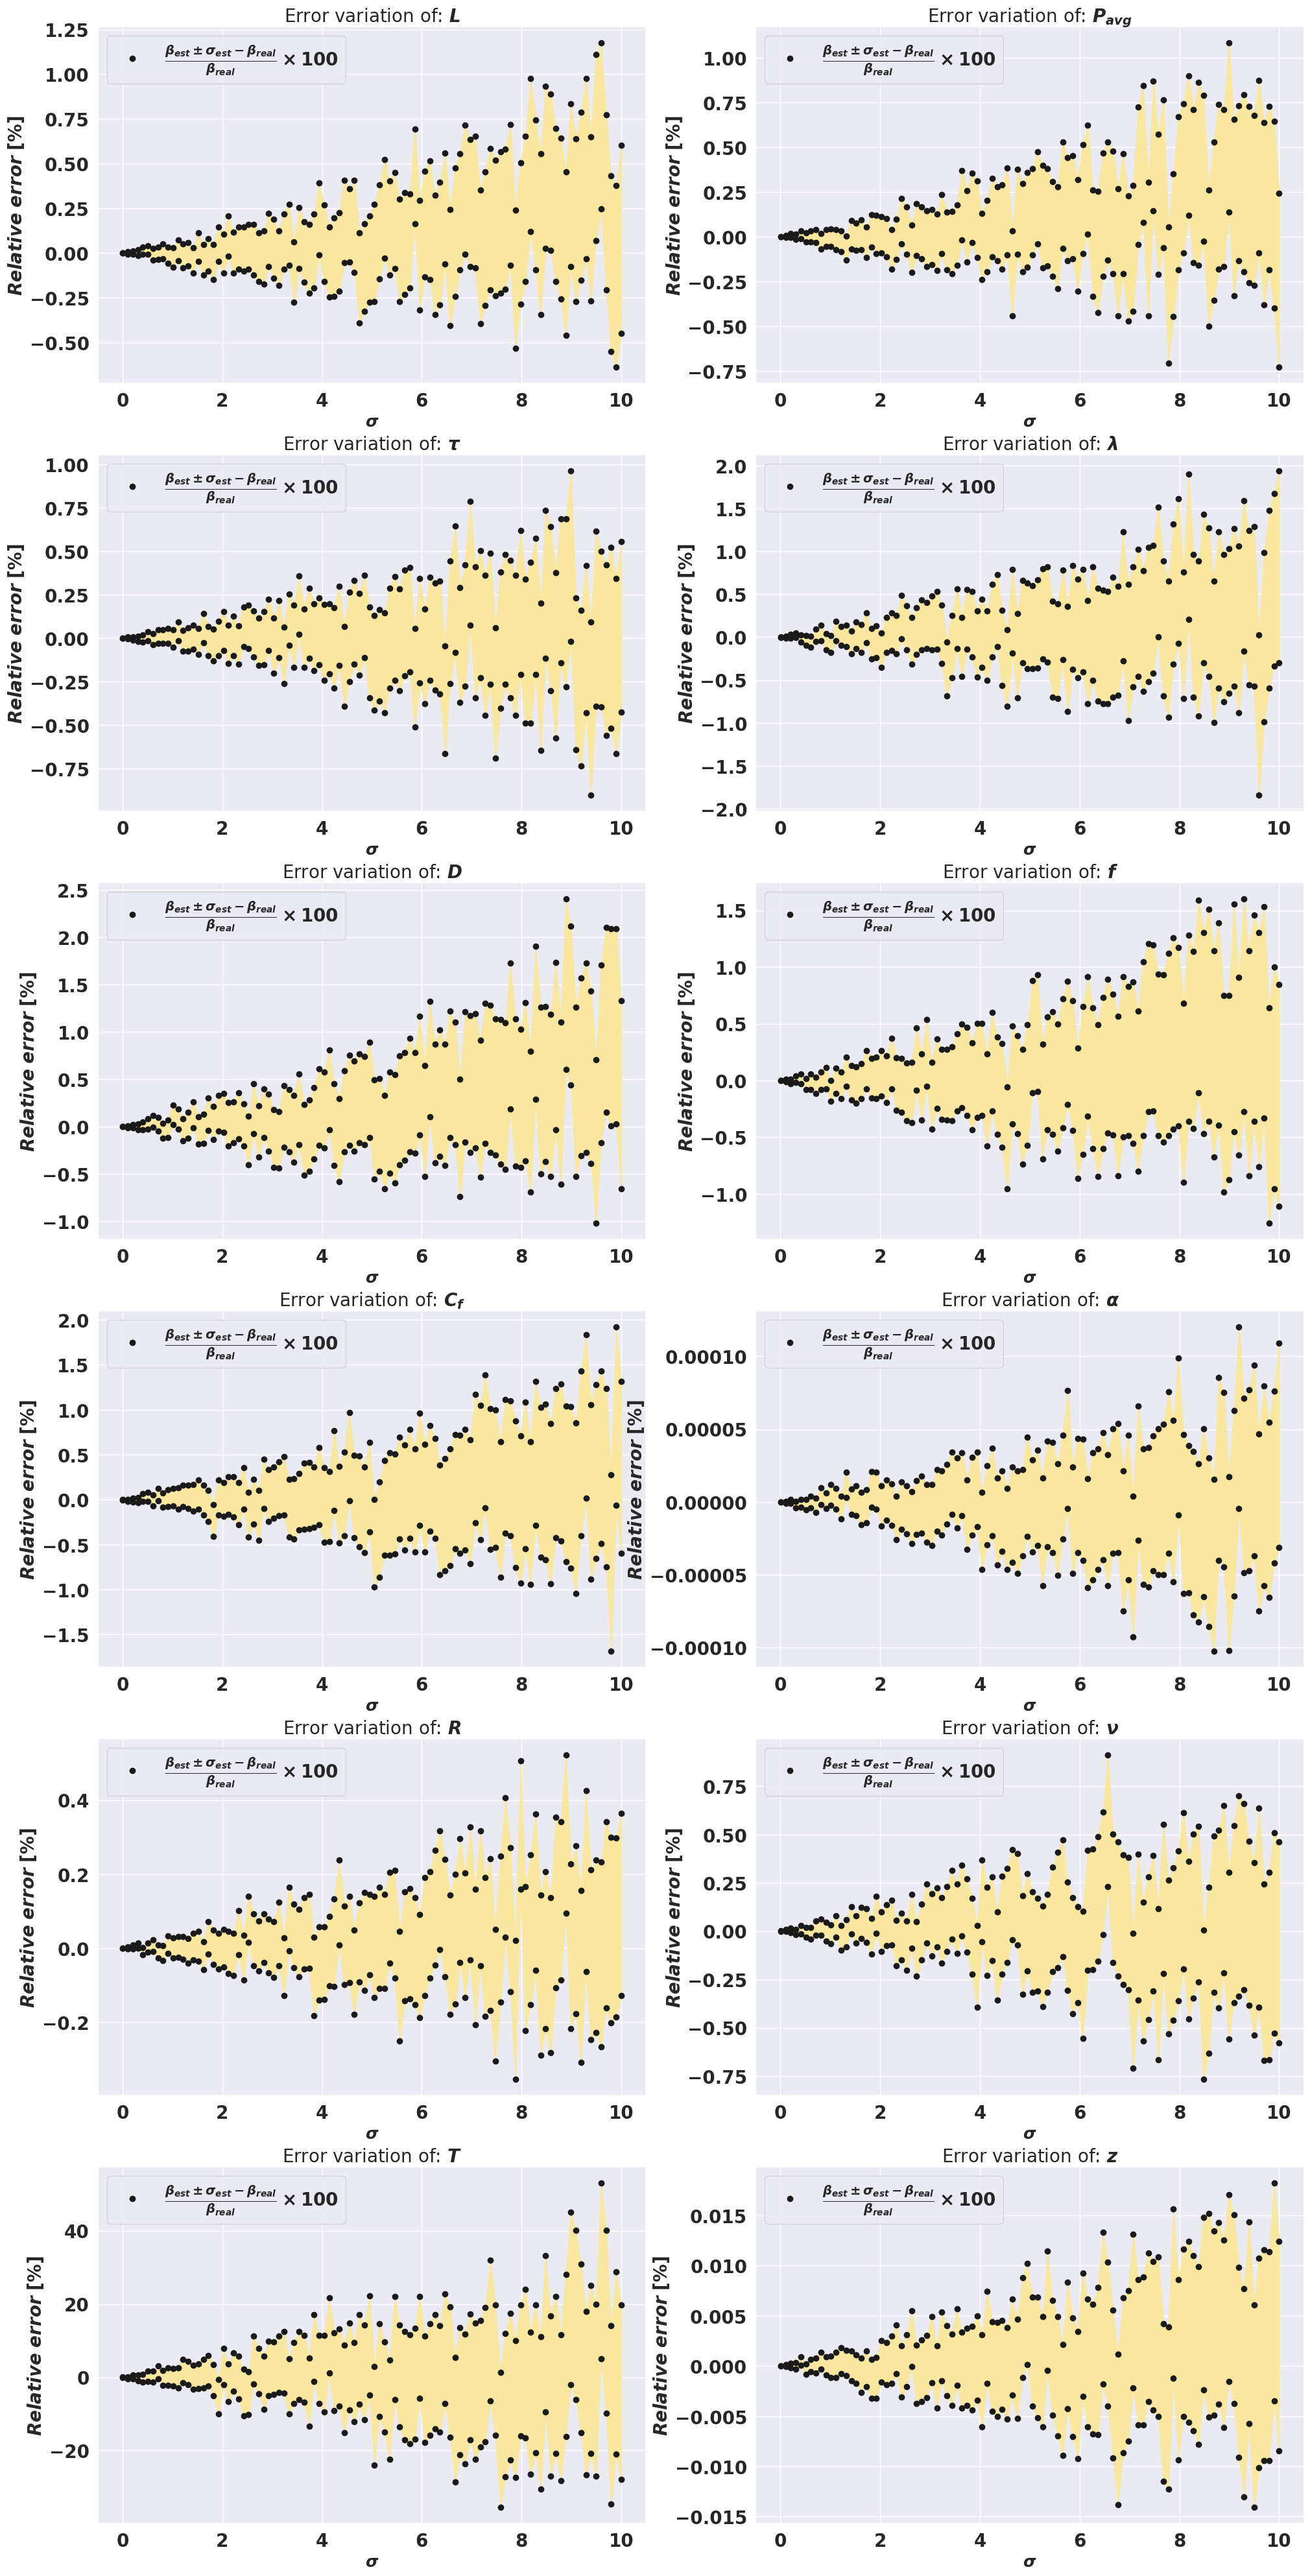

In [17]:
f=plt.figure(figsize=(24,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for i in range(0,12): 

    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100


    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Desviacion relativa.


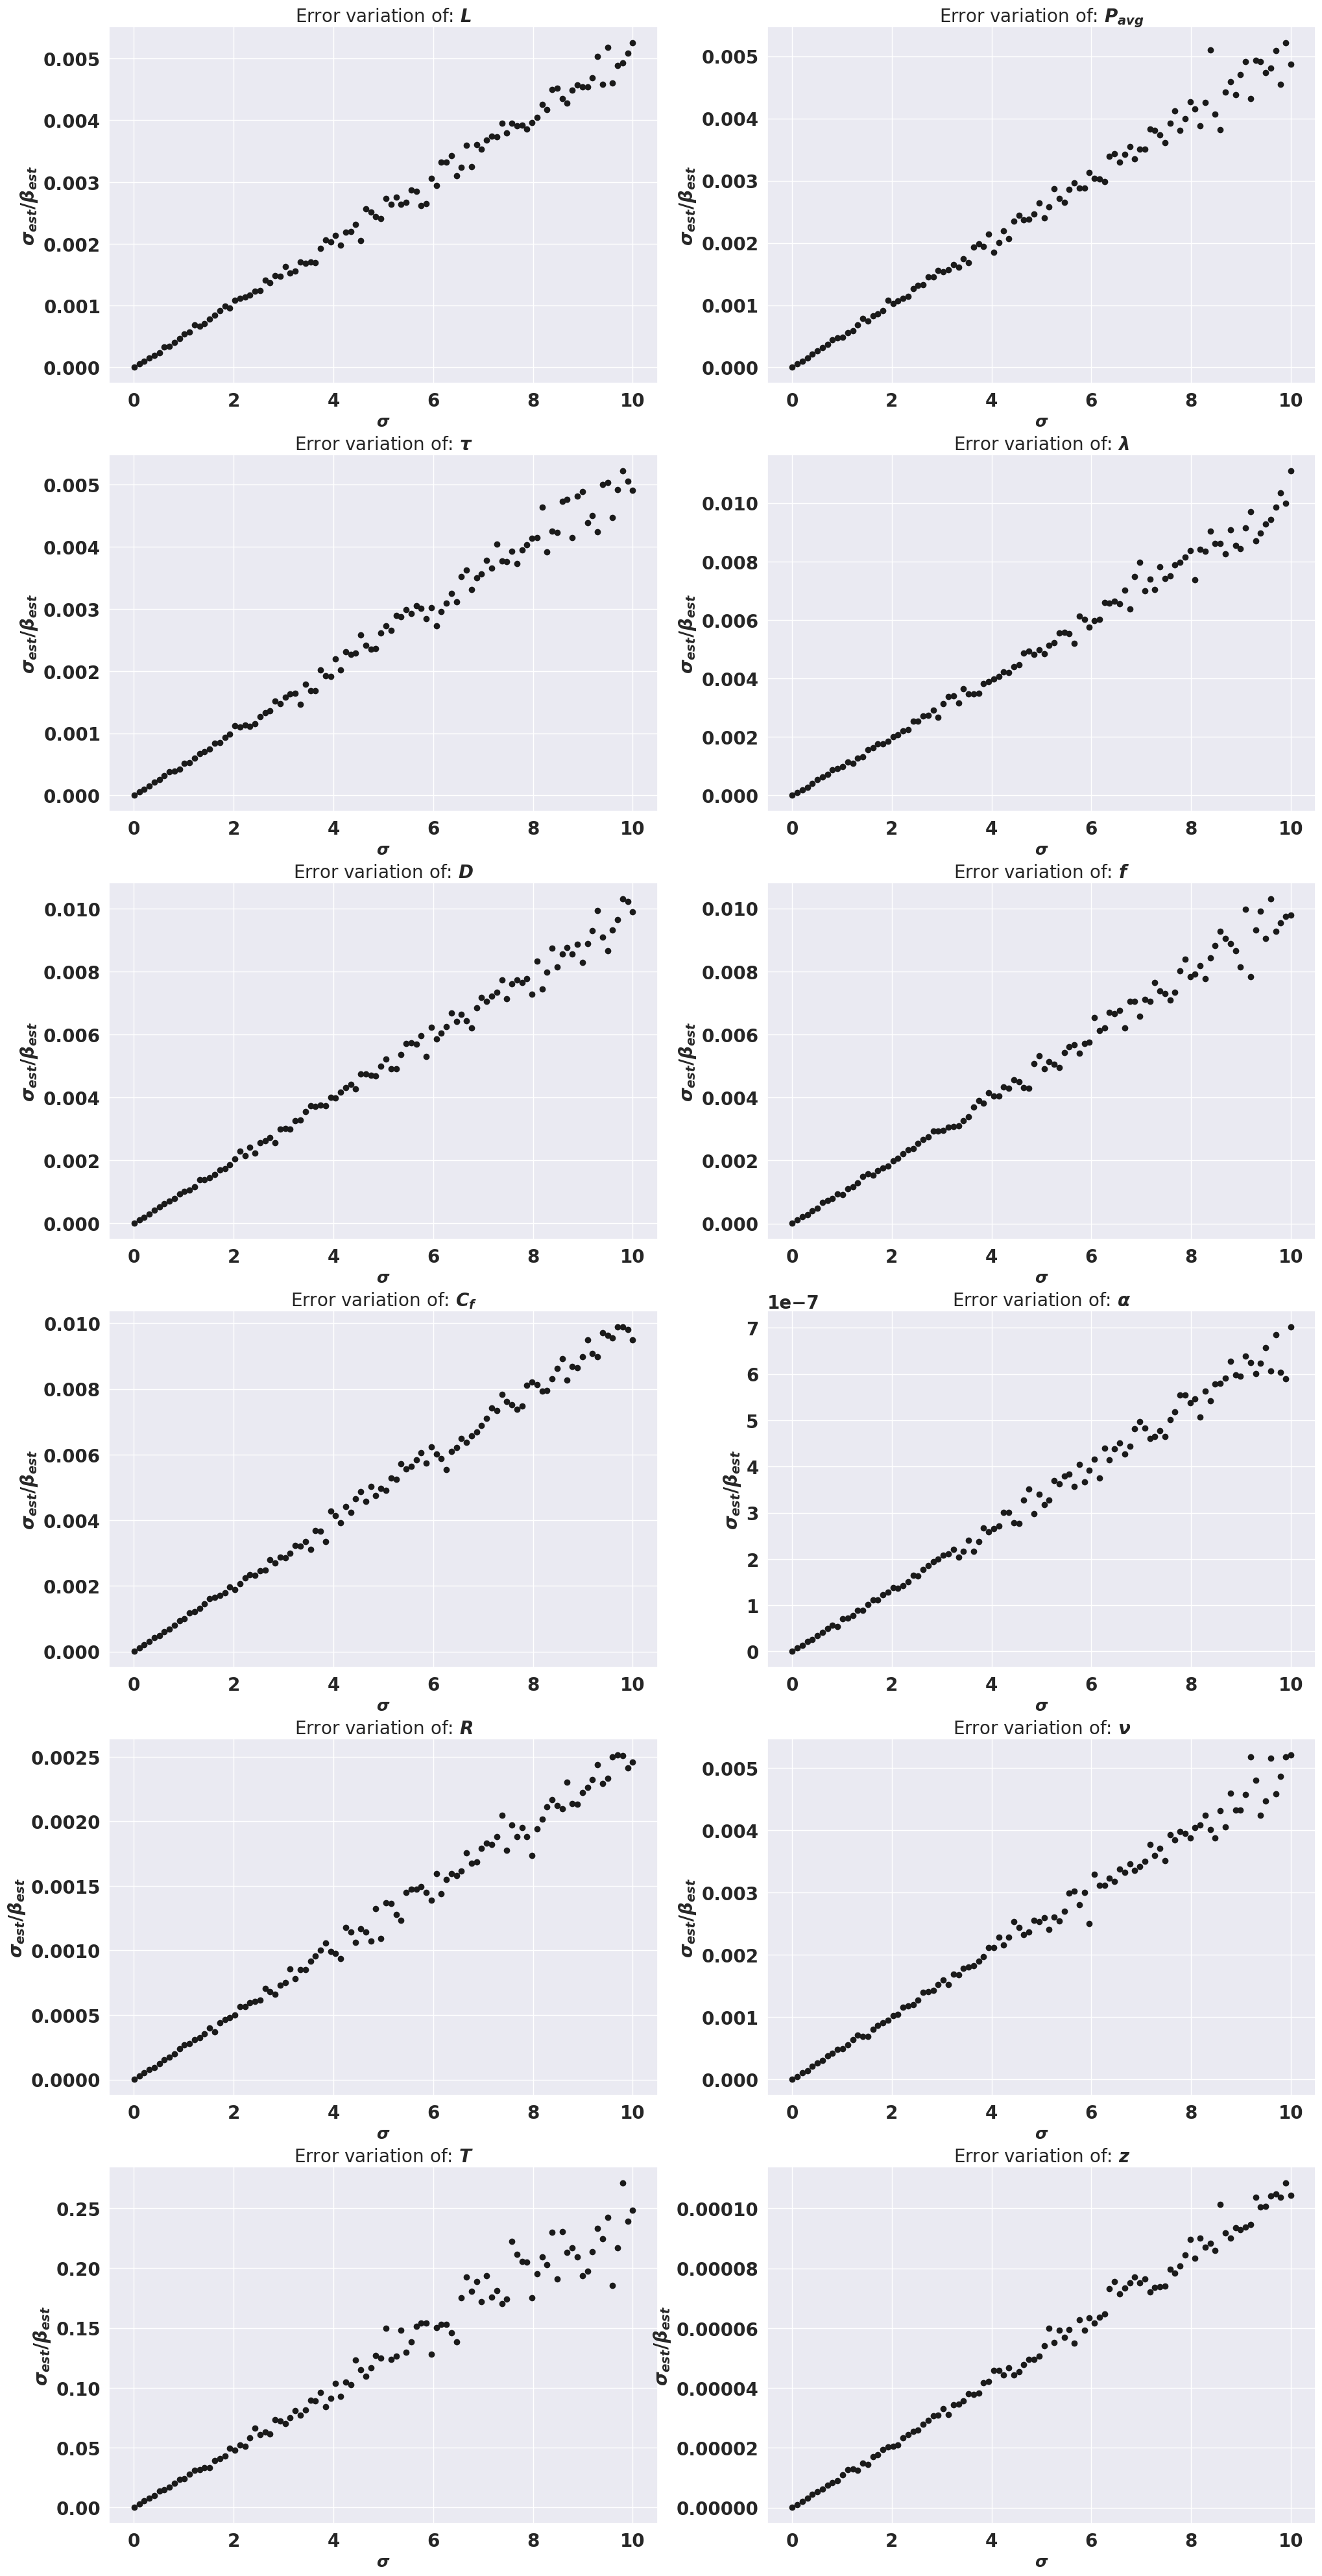

In [18]:
f=plt.figure(figsize=(24,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for i in range(0,12): 

    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    plt.subplot(6,2,iters)
    plt.plot(er_r,desvf2/muf2,'ko')
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    #plt.legend(fontsize=20)
    #plt.fill_between(er_r,err_max,err_min,color='#f9e79f')
    iters+=1

    

# Analisis perspectiva 2.

Se procede a realizar el mismo analisis que en el caso de la perspectiva 1.

In [19]:
# Función ajustar
def BETA2(trans,z,focal,L,Pavg,Tp,wl,D,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + (z/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    h=1
    r=-1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((z)/z0)**2)
    b=sum(r[i]*(trans[i]-h) for i in range(len(trans)))/sum(r[i]**2 for i in range(len(trans)))
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b

def dist_betas2(N,desv,params): 
  '''
  Implementación de protocolo de ajuste para el calculo de beta
  usando como metrica de ajuste el $\chi$²

  Parametros
  ----------
  T_ruido: Arreglo
      Arreglo con Datos ajustar.
  focal: Arreglo
      Arreglo con distancias focales utilizadas.
  ruido: Número
      Ruido que se le ha añadido a la señal teorica.

  La función devuelve el mejor valor de TPA y su error estandar
  '''
  # Contedra valores de TPA
  TPA=[]
  er=desv/(1.96*100)
  
  for ii in range(N):
      
      TT=list(fscanTH2(z,focal,beta,L,Pavg,Tp,wl,D,Cf,alfa,R,freq)) #Señal simulada
      er_L=er*params[0]
      er_P=er*params[1]
      er_T=er*params[2]
      er_wl=er*params[3]
      er_D=er*params[4]
      er_focal=er*params[5]
      er_Cf=er*params[6]
      er_a=er*params[7]
      er_R=er*params[8]
      er_freq=er*params[9]
      er_trans=er*params[10]
      er_z=er*params[11]
      trans_f=ruido(TT,er_trans) #Minimo de la señal simulada. 
      z_f=ruido(z,abs(er_z))  #Distancia focal correspondiente al minimo.   
      L_f = np.random.normal(L,L*er_L,1) # # thickness in (m).
      Pavg_f = np.random.normal(Pavg,Pavg*er_P,1) # Average power in (W)
      Tp_f = abs(np.random.normal(Tp,Tp*er_T,1)) # Pulse width FWHM in (s). sech
      wl_f = np.random.normal(wl,wl*er_wl,1) #central wavelength in (m)
      D_f = np.random.normal(D,D*er_D,1) # beam diameter in (m)
      focal_f = np.random.normal(focal,focal*er_focal,1) # EFTL-sample distance (m)
      Cf_f = np.random.normal(Cf,Cf*er_Cf,1) # Beam correction factor
      alfa_f =  abs(np.random.normal(alfa,alfa*er_a,1)) #linear absorption (1/m)
      R_f = np.random.normal(R,R*er_R,1) # Reflectance
      freq_f = np.random.normal(freq,freq*er_freq,1) # Reflectance   
      TPA.append(BETA2(trans_f,z_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,Cf_f,alfa_f,R_f,freq_f)*1e11)
          
  return TPA


# Variación en el error de todos los parametros.

In [20]:
desvf=[]
muf=[]
decis=[]
params=np.ones(12)
er_r=np.linspace(0.005,10,100) #Porcentaje de error

for c in er_r:
    
    beta_hist=np.array(dist_betas2(500,c,params))
    d1=confirm_gauss(beta_hist)
    decis.append(d1)
    if d1==1:
        (mu, sigma) = norm.fit(beta_hist)
        muf.append(mu)
        desvf.append(sigma)
    else:
        muf.append(np.mean(beta_hist))
        desvf.append(np.std(beta_hist,ddof=1))

for i in range(len(decis)):

    if i<=(len(decis)-4):

        if ((decis[i]==0) and (decis[i+1]==0) and (decis[i+2]==0) and (decis[i+3]==0)):
            
            lim=i
            break
      
    else:
        lim=i

    
muf=np.array(muf)
desvf=np.array(desvf)
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


"\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96\\sigma_{est}$')\nplt.ylabel(r'$\x08eta_{est}$',fontsize=15)\nplt.xlabel(r'$\\sigma_{est}$',fontsize=15)\nplt.legend()\n"

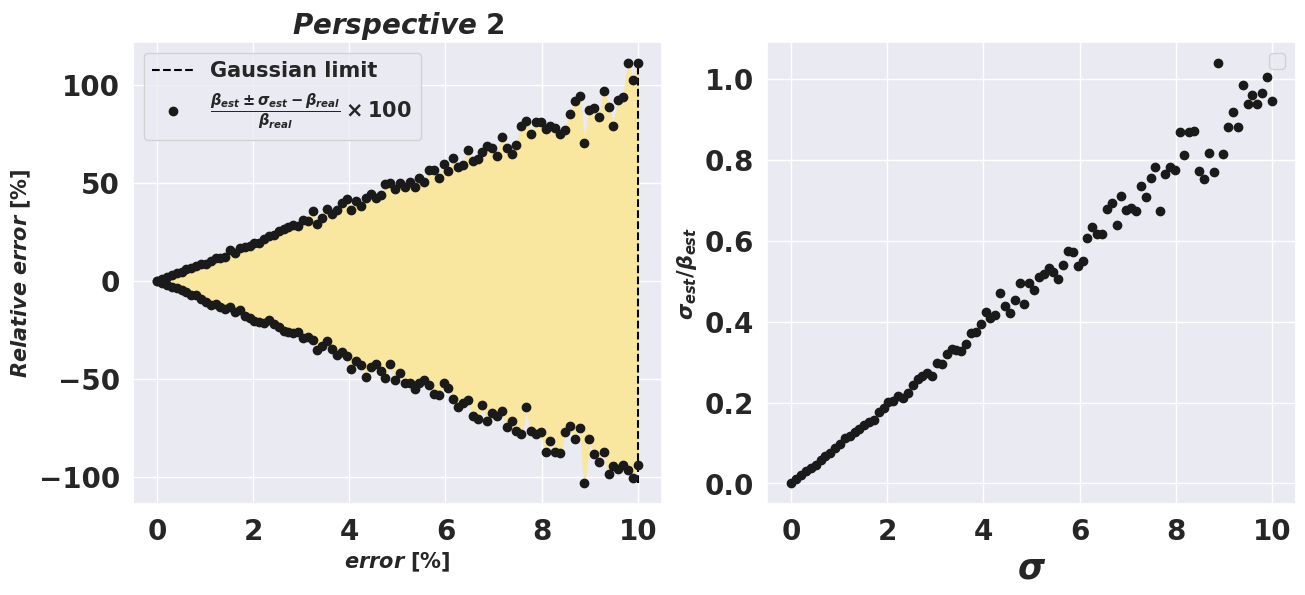

In [21]:
f=plt.figure(figsize=(15,6))

plt.subplot(121)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)
plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Perspective$ $2$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')


plt.subplot(122)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma$',fontsize=25)
plt.plot(er_r,desvf/muf,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
#plt.title('$Focal$ $distance: $'+str(round(100*focal[n]))+' $cm$',fontsize=20)
plt.legend(fontsize=15)



'''
f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variación en el error por parametro.

In [22]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=np.array(dist_betas2(500,j,params[i,:]))
        criterio=confirm_gauss(beta_hist)
        final.append(criterio)
    

        if criterio==1:


            (mu, sigma) = norm.fit(beta_hist)
            muf2.append(mu)
            desvf2.append(sigma)


        else:


            muf2.append(np.mean(beta_hist))
            desvf2.append(np.std(beta_hist,ddof=1))
    
    
    gauss_final.append(final)
    results_mus.append(muf2)
    results_sigmas.append(desvf2)


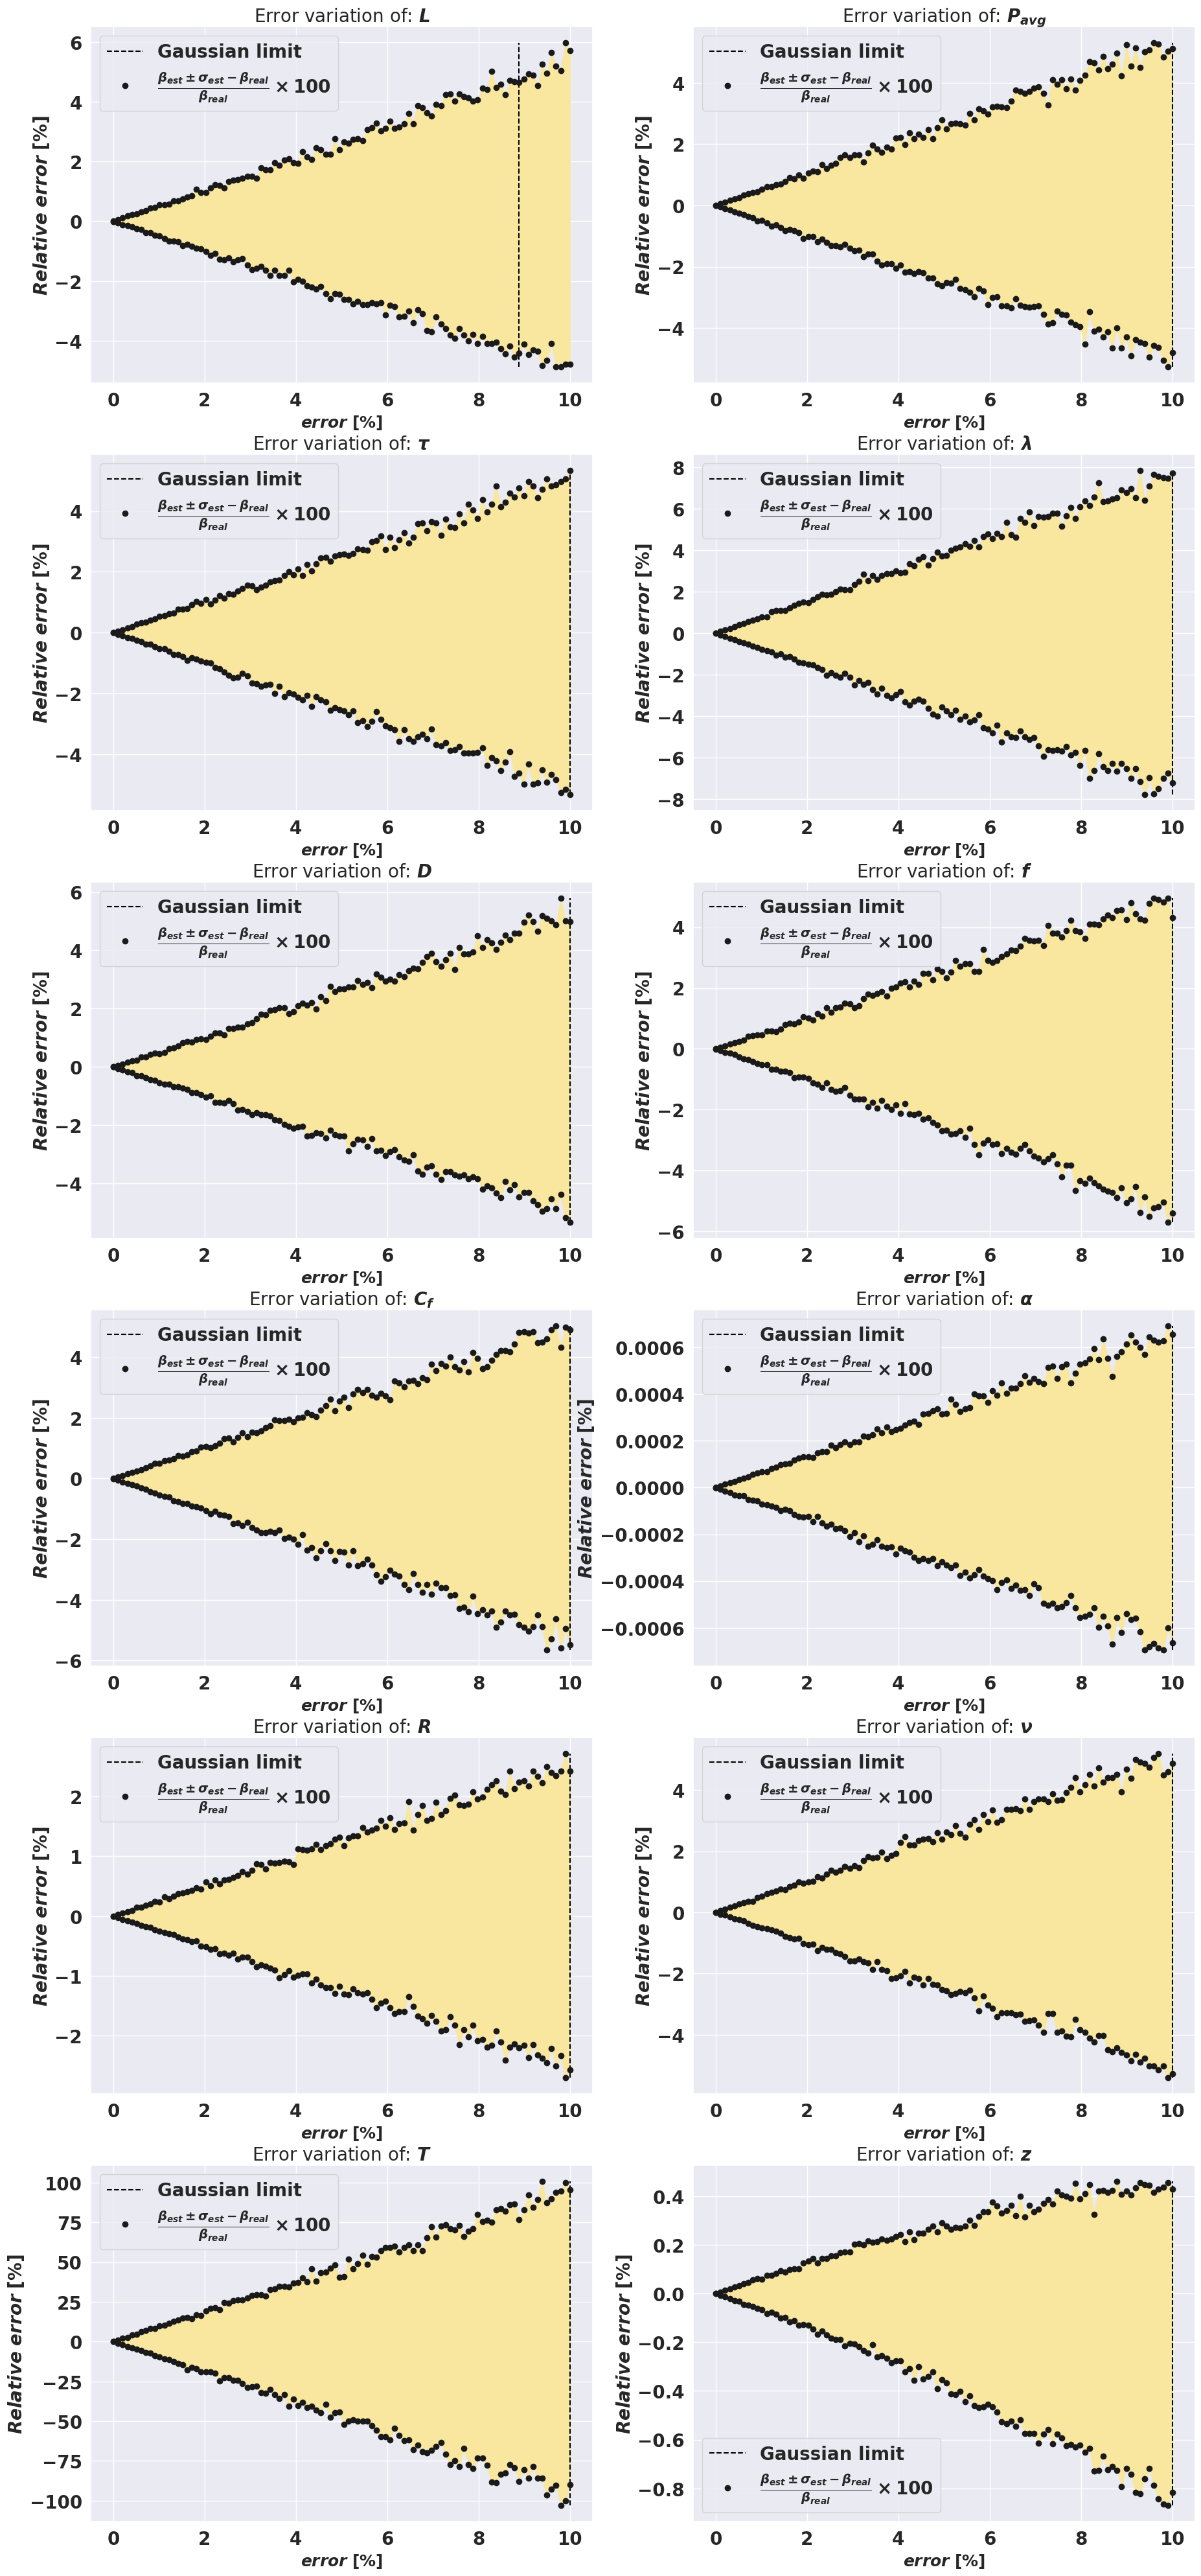

In [23]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for i in range(0,12):

    for j in range(0,len(gauss_final[i])): 
                 
        if j<=(len(gauss_final[i])-4):

            if ((gauss_final[i][j]==0) and (gauss_final[i][j+1]==0) and (gauss_final[i][j+2]==0) and (gauss_final[i][j+3]==0)) :
                
                    lim=j
                    break
        else:
            lim=j


    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100


    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel(r'$error$ $[\%]$',fontsize=18)
    plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

# Incertidumbre relativa.

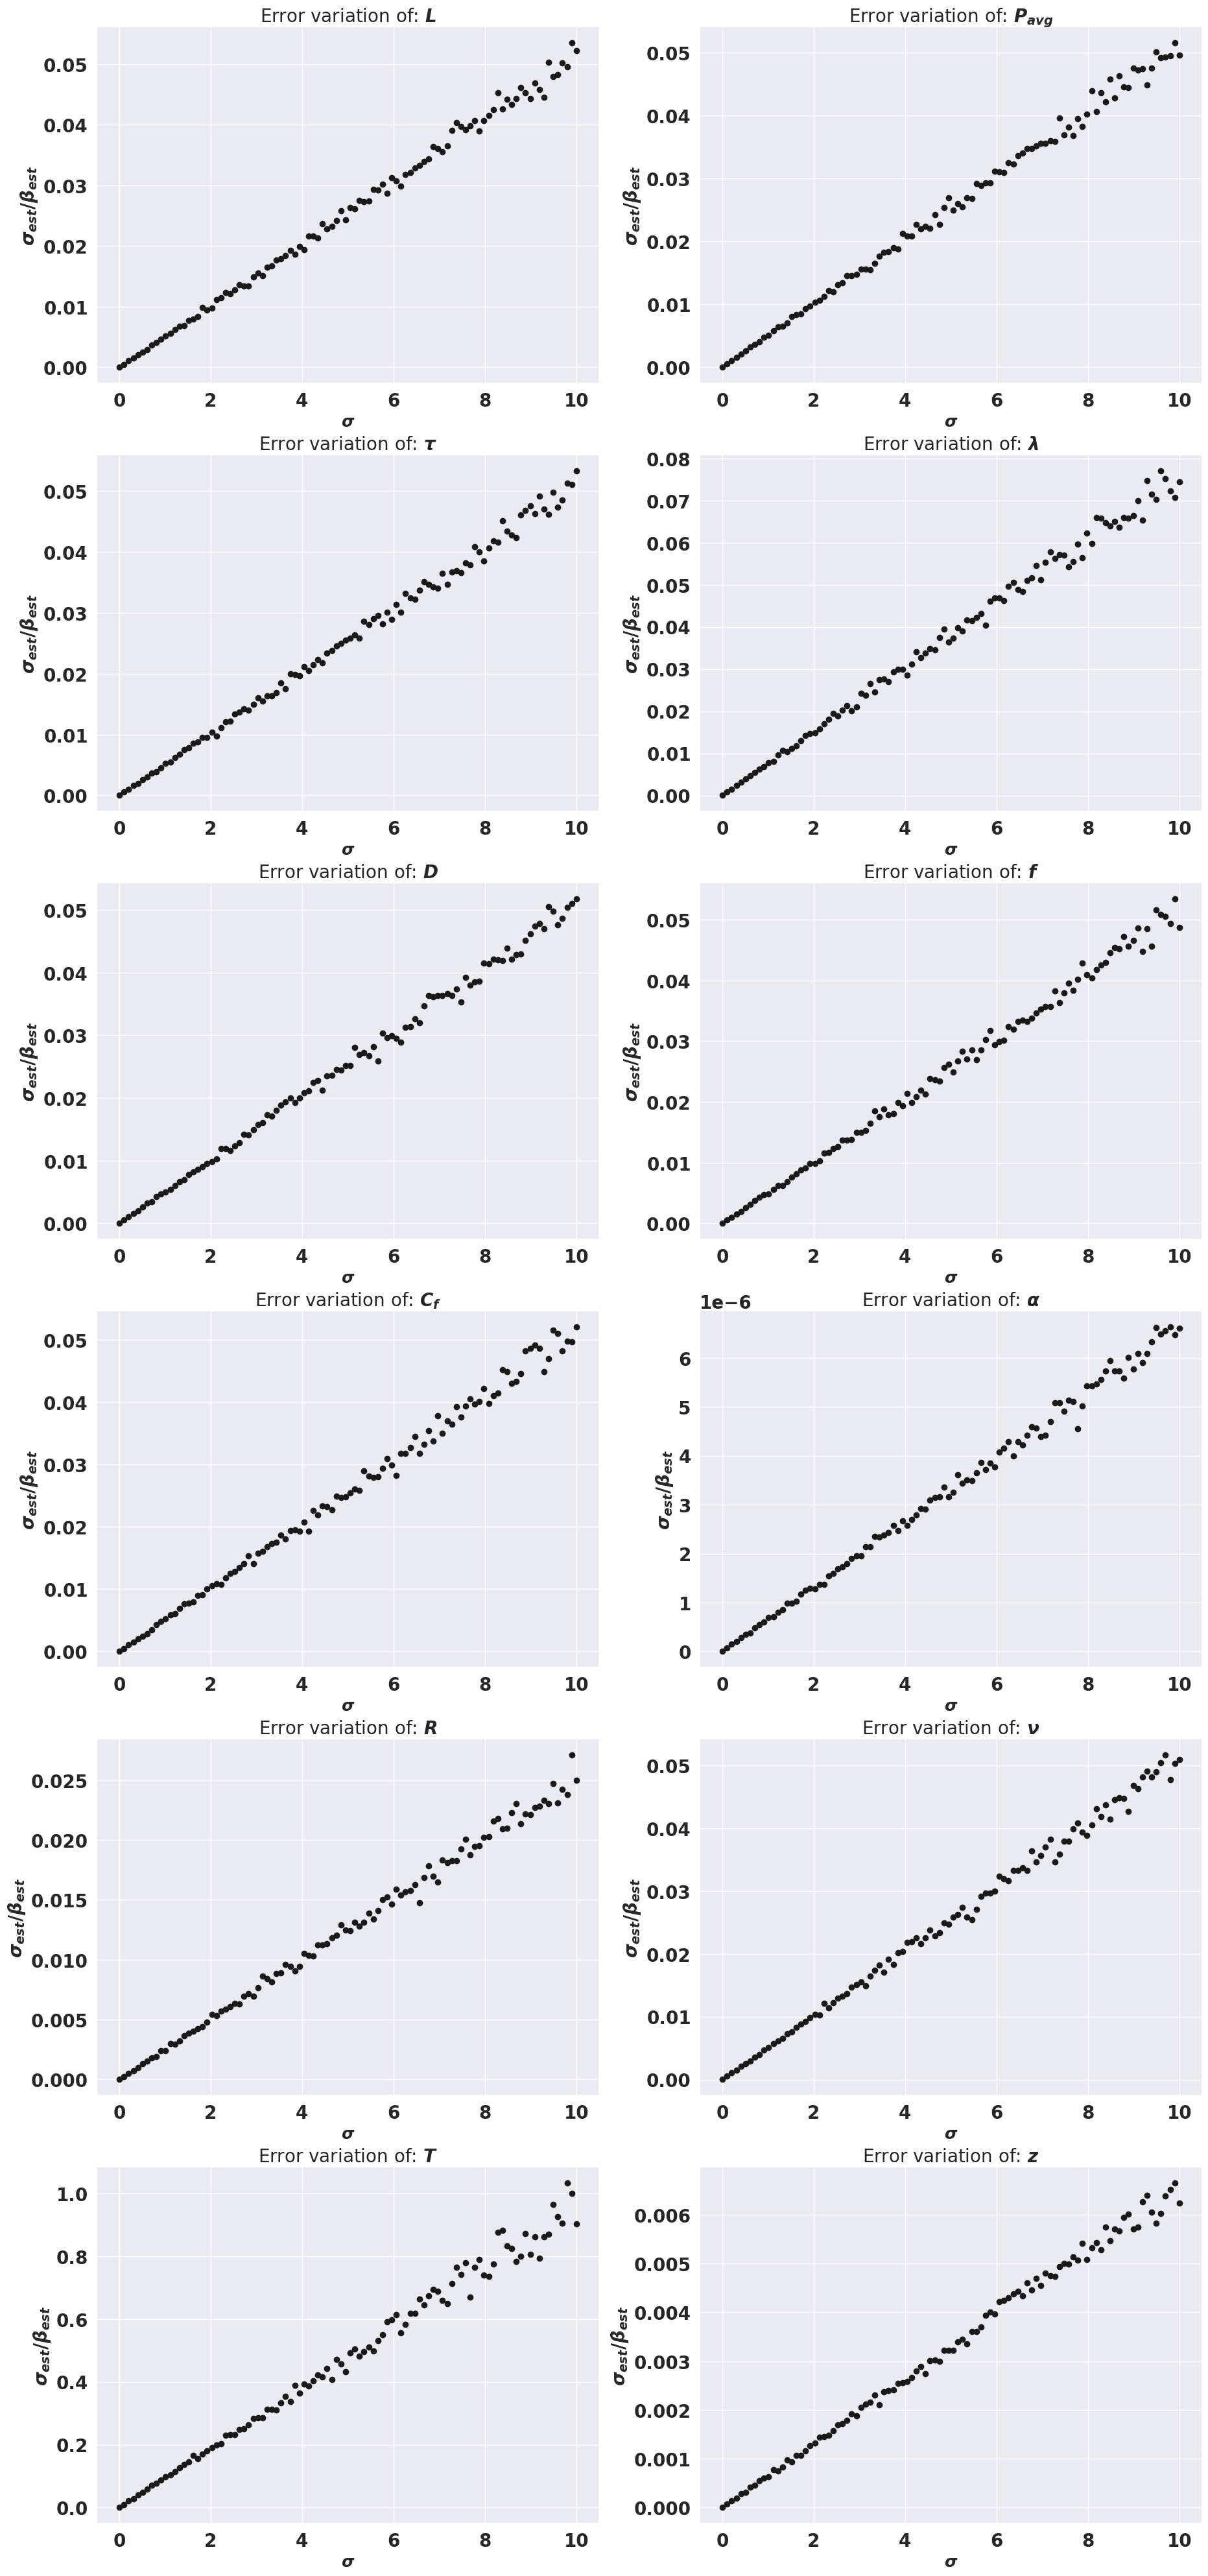

In [24]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$f$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$z$']
iters=1

for i in range(0,12):

  
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    


    plt.subplot(6,2,iters)
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
    plt.plot(er_r,desvf2/muf2,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    

    iters+=1

    

# Analisis teorema de limite central

In [25]:
er_r=np.linspace(0.005,10,100) #Porcentaje de error
N=250
mus=[]
sigmas=[]
params=np.ones(12)
dec=[]

for c,j in enumerate(er_r):


    beta_hist=central(np.array(dist_betas2(N,j,params)),100)
    mus.append(np.mean(beta_hist))
    sigmas.append(np.std(beta_hist))

In [26]:
muf=np.array(mus)
desvf=np.array(sigmas)
err_max=(np.array(muf)+desvf-beta*1e11)/(beta*1e11)*100
err_min=(np.array(muf)-desvf-beta*1e11)/(beta*1e11)*100

"\nf=plt.figure(figsize=(10,4))\nplt.plot(desvf,muf,'o',label='Simulated values')\ndesvf=np.array(desvf)\ny1=beta*1e11+desvf\ny2=beta*1e11-desvf\nplt.plot(desvf,y1,'r',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}+1.96\\sigma_{est}$')\nplt.plot(desvf,y2,'k',linewidth=3,label=r'$\x08eta_{est}=\x08eta_{real}-1.96\\sigma_{est}$')\nplt.ylabel(r'$\x08eta_{est}$',fontsize=15)\nplt.xlabel(r'$\\sigma_{est}$',fontsize=15)\nplt.legend()\n"

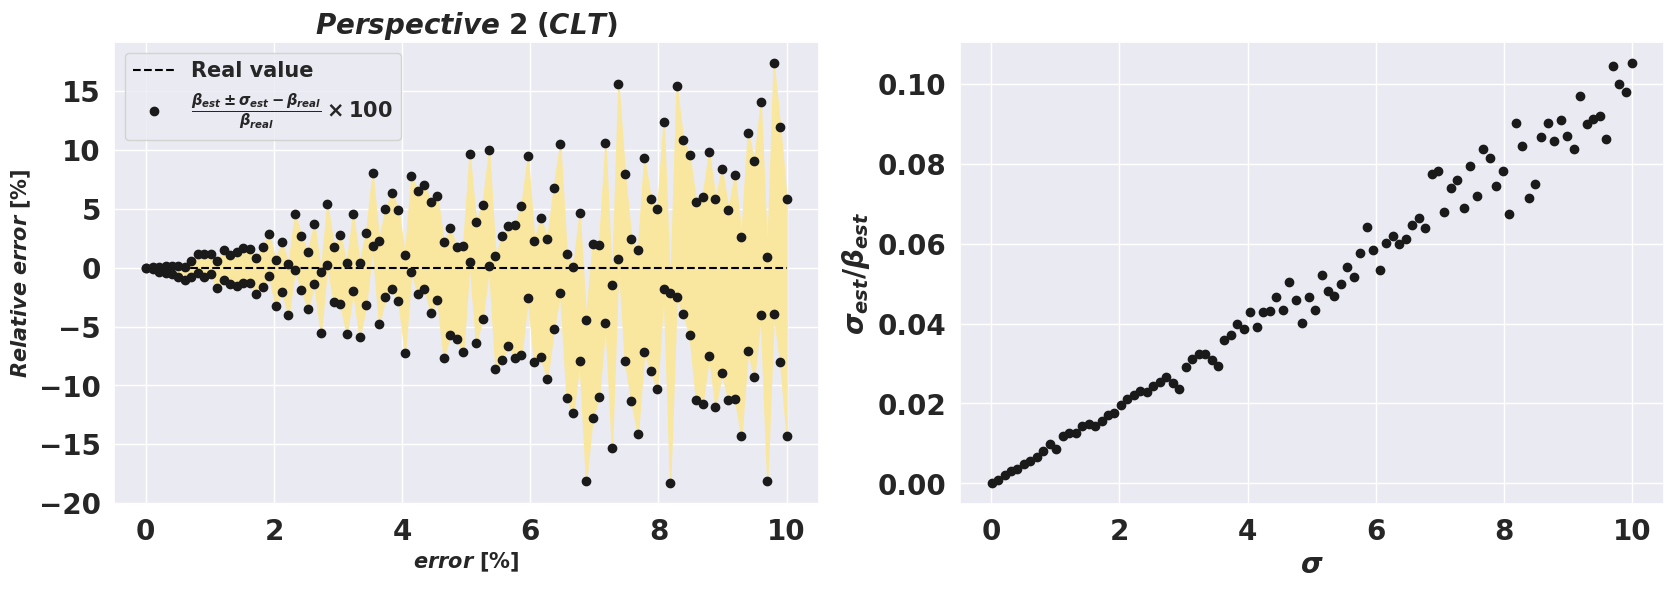

In [27]:
f=plt.figure(figsize=(20,6))

plt.subplot(121)
plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=15)
plt.xlabel(r'$error$ $[\%]$',fontsize=15)
plt.hlines(0,xmin=min(er_r),xmax=max(er_r),label='Real value',color='black',linestyles='--')
plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
plt.plot(er_r,err_min,'ko')
#plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
plt.title('$Perspective$ $2$ $(CLT)$',fontsize=20)
plt.legend(fontsize=15)
plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

plt.subplot(122)
plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
plt.xlabel(r'$\sigma$',fontsize=20)
plt.plot(er_r,desvf/muf,'ko')




'''
f=plt.figure(figsize=(10,4))
plt.plot(desvf,muf,'o',label='Simulated values')
desvf=np.array(desvf)
y1=beta*1e11+desvf
y2=beta*1e11-desvf
plt.plot(desvf,y1,'r',linewidth=3,label=r'$\beta_{est}=\beta_{real}+1.96\sigma_{est}$')
plt.plot(desvf,y2,'k',linewidth=3,label=r'$\beta_{est}=\beta_{real}-1.96\sigma_{est}$')
plt.ylabel(r'$\beta_{est}$',fontsize=15)
plt.xlabel(r'$\sigma_{est}$',fontsize=15)
plt.legend()
'''

# Variación de un solo parametro.

In [28]:
results_mus=[]
results_sigmas=[]
er_r=np.linspace(0.005,10,100) #Porcentaje de error
params=np.diag(np.ones(12))
gauss_final=[]


for i in range(0,12):
    
    final=[]
    muf2=[]
    desvf2=[]

    for c,j in enumerate(er_r):


        beta_hist=central(np.array(dist_betas2(500,j,params[i,:])),100)
        muf2.append(np.mean(beta_hist))
        desvf2.append(np.std(beta_hist))

    results_mus.append(muf2)
    results_sigmas.append(desvf2)


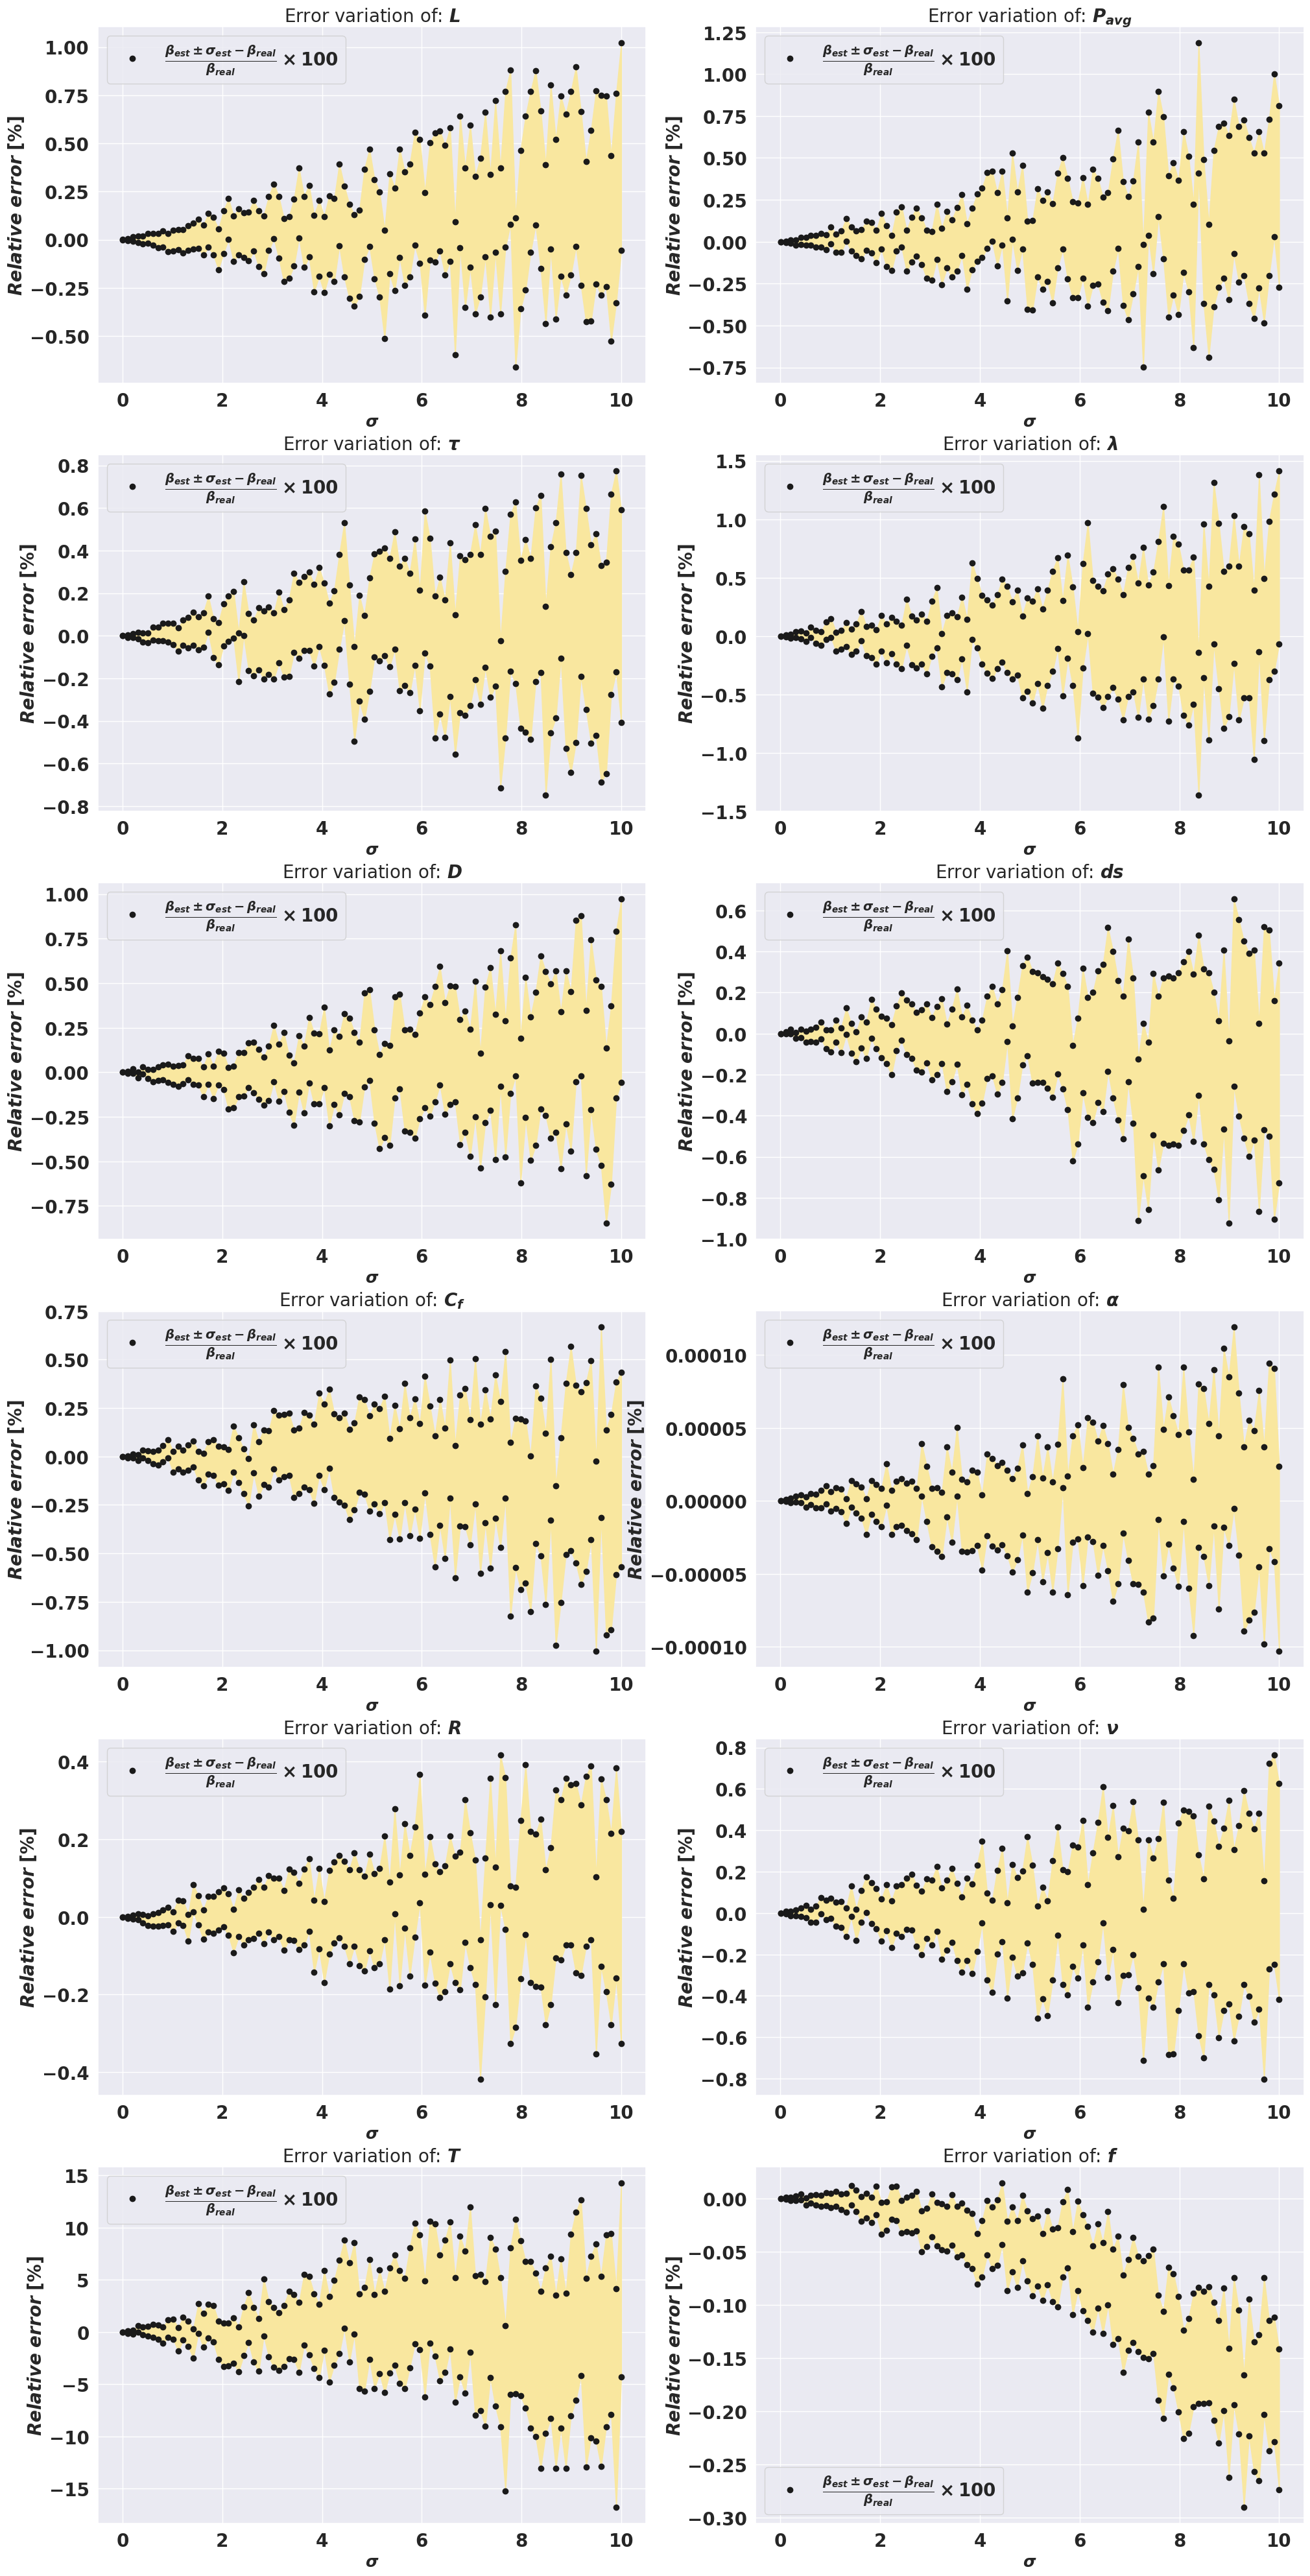

In [29]:
f=plt.figure(figsize=(24,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12): 

    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    err_max=(np.array(muf2)+desvf2-beta*1e11)/(beta*1e11)*100
    err_min=(np.array(muf2)-desvf2-beta*1e11)/(beta*1e11)*100


    plt.subplot(6,2,iters)
    plt.ylabel(r'$Relative$ $error$ $[\%]$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
    #plt.vlines(er_r[lim],ymin=min(err_min),ymax=max(err_max),label='Gaussian limit',color='black',linestyles='--')
    plt.plot(er_r,err_max,'ko',label=r'$\frac{ \beta_{est}\pm \sigma_{est}-\beta_{real}}{\beta_{real}} \times 100$')
    plt.plot(er_r,err_min,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    plt.legend(fontsize=20)
    plt.fill_between(er_r,err_max,err_min,color='#f9e79f')

    iters+=1

    

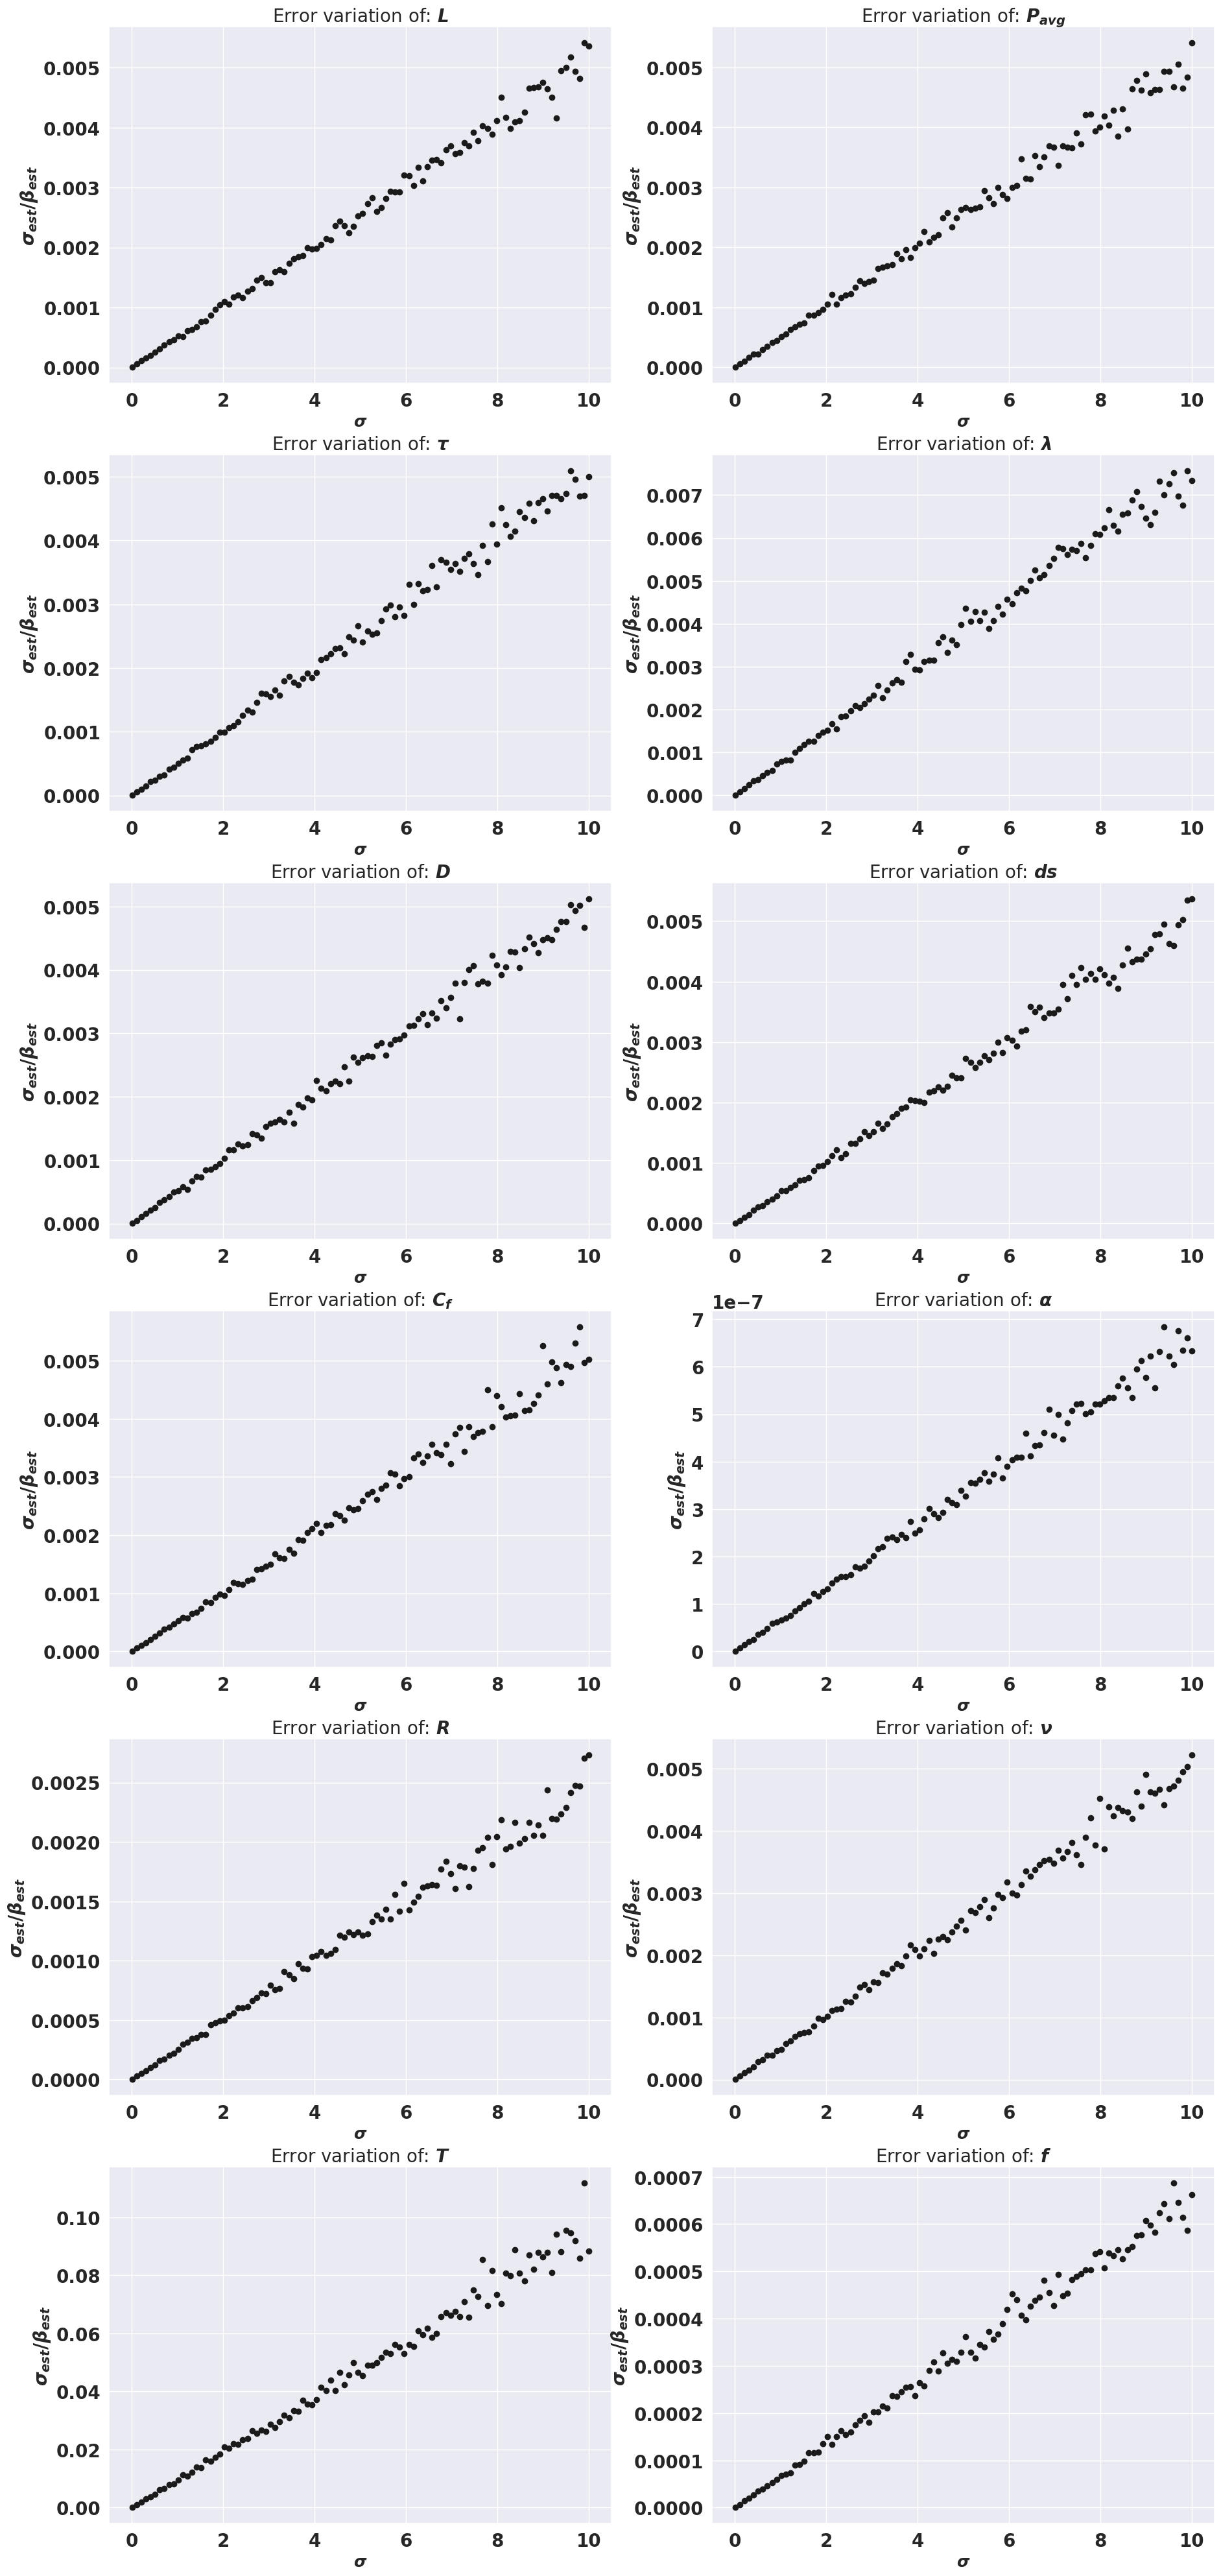

In [30]:
f=plt.figure(figsize=(22,50))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
titles=[r'$L$',r'$P_{avg}$',r'$\tau$',r'$\lambda$',r'$D$',r'$ds$',r'$C_{f}$',r'$\alpha$',r'$R$',r'$\nu$',r'$T$',r'$f$']
iters=1

for i in range(0,12):

  
    muf2=np.array(results_mus[i])
    desvf2=np.array(results_sigmas[i])
    


    plt.subplot(6,2,iters)
    plt.ylabel(r'$\sigma_{est}/\beta_{est}$',fontsize=20)
    plt.xlabel(r'$\sigma$',fontsize=18)
   
    plt.plot(er_r,desvf2/muf2,'ko')
    #plt.plot(er_r,err_min,'bo',label=r'$\frac{\left | \beta_{est}-\sigma_{est}-\beta_{real} \right |}{\beta_{real}}$')
    plt.title(r'Error variation of: '+titles[i],fontsize=20)
    

    iters+=1

    